# Algebra of Failure Inducing Input Patterns

 We are trying to generate grammars that produce inputs that contain or does not specific behaviors (or complex combinations thereof). To do that, we extract the abstract syntactical patterns that correspond to given behaviors, and then generate a refinement grammar from the original grammar that follows the algebraic specifications. So, one can say things of the sort: I want to generate inputs with parenthesis, but discard everything with doubled parenthesis.

While boolean grammars are the formalism for such things (e.g A & B & !C), and one can trivially construct multi-level recognizers for it (parse A, parse B, not parse C), generation is much harder, and as far as I can see, no one has found a way to easily generate inputs from such expressions (other than the generate and filter approach, which is really inefficient). Further, the boolean grammars are already beyond context free grammars, and our current techniques will not work on them. What we do here, is to recognize that for fault pattern additions and removal, one can stick to a context-free subset, and one can guarantee the properties of the resulting grammar.



The main question being asked is, how to combine and negate fault patterns.

In [1]:
import copy

The faults can from several different inputs. The idea is that the characterizing node, and abstraction removes the influences of the specific parse tree.

## Fault Patterns

We define an input from which we extract our patterns. Note that we do not use the predicate; rather we assume that we already have a few such predicates.

In [2]:
expr_input =  '1 + ((2 * 3 / 4))'

### Grammar

A context-free grammar is represented as a Python dict, with each nonterminal symbol forming a key, and each nonterminal _defined_ by a list of expansion rules. For example, the expression grammar for parsing arithmetic expressions is given below.

In [3]:
EXPR_GRAMMAR = {'<start>': [['<expr>']],
 '<expr>': [['<term>', ' + ', '<expr>'],
  ['<term>', ' - ', '<expr>'],
  ['<term>']],
 '<term>': [['<factor>', ' * ', '<term>'],
  ['<factor>', ' / ', '<term>'],
  ['<factor>']],
 '<factor>': [['+', '<factor>'],
  ['-', '<factor>'],
  ['(', '<expr>', ')'],
  ['<integer>', '.', '<integer>'],
  ['<integer>']],
 '<integer>': [['<digit>', '<integer>'], ['<digit>']],
 '<digit>': [['0'], ['1'], ['2'], ['3'], ['4'], ['5'], ['6'], ['7'], ['8'], ['9']]}

In [4]:
EXPR_G = {'[start]': '<start>', '[grammar]': EXPR_GRAMMAR}

Note the convetion we used: Each nonterminal is enclosed in angle brackets. E.g. `<expr>`. We now define a function that can distinguish terminal symbols from nonterminals.

The `is_nt()` function checks if the given node is a terminal or not.

In [5]:
def is_nt(symbol):
     return symbol and (symbol[0], symbol[-1]) == ('<', '>')

#### The Parser

Given the grammar, and an input, we can parse it into a derivation tree.
The `Parser` below is from [fuzzingbook.org](https://www.fuzzingbook.org/html/Parser.html), and provides a generic context-free parser. This is present in the `src` directory.

In [6]:
from Parser import EarleyParser as Parser

How do we check that our parse succeeded? We can convert the derivation tree back to the original string and check for equality.

The `tree_to_str()` function converts a derivation tree to its original string.

In [7]:
def tree_to_str(node):
    name, children, *rest = node
    if not children:
        return name
    return ''.join([tree_to_str(c) for c in children])

In [8]:
Ts = tree_to_str

In [9]:
expr_parser = Parser(EXPR_GRAMMAR, start_symbol='<start>', canonical=True)
parsed_expr = list(expr_parser.parse(expr_input))[0]
tree_to_str(parsed_expr)

'1 + ((2 * 3 / 4))'

#### Display

While converting to strings are easy, it is unsatisfying. We want to make our output look pretty, and inspect the tree structure of the parsed tree. So we define graphical tree display (code from fuzzingbook)

In [10]:
from graphviz import Digraph

In [11]:
from IPython.display import display, Image

In [12]:
def zoom(v, zoom=True):
    # return v directly if you do not want to zoom out.
    if zoom:
        return Image(v.render(format='png'))
    return v

In [13]:
class DisplayTree():
    def __init__(self):
        pass

    def extract_node(self, node, id):
        symbol, children, *annotation = node
        return symbol, children, ''.join(str(a) for a in annotation)
    
    def node_attr(self, dot, nid, symbol, ann):
        dot.node(repr(nid), symbol + ' ')
        
    def edge_attr(self, dot, start_node, stop_node):
        dot.edge(repr(start_node), repr(stop_node))
        
    def graph_attr(self, dot):
        dot.attr('node', shape='plain')
        
    def display(self, derivation_tree):
        counter = 0
        def traverse_tree(dot, tree, id=0):
            (symbol, children, annotation) = self.extract_node(tree, id)
            self.node_attr(dot, id, symbol, annotation)
            if children:
                for child in children:
                    nonlocal counter
                    counter += 1
                    child_id = counter
                    self.edge_attr(dot, id, child_id)
                    traverse_tree(dot, child, child_id)
        dot = Digraph(comment="Derivation Tree")
        self.graph_attr(dot)
        traverse_tree(dot, derivation_tree)
        return dot
    
    def __call__(self, dt):
        return self.display(dt)

In [14]:
display_tree = DisplayTree()

We are now ready to display the tree structure.

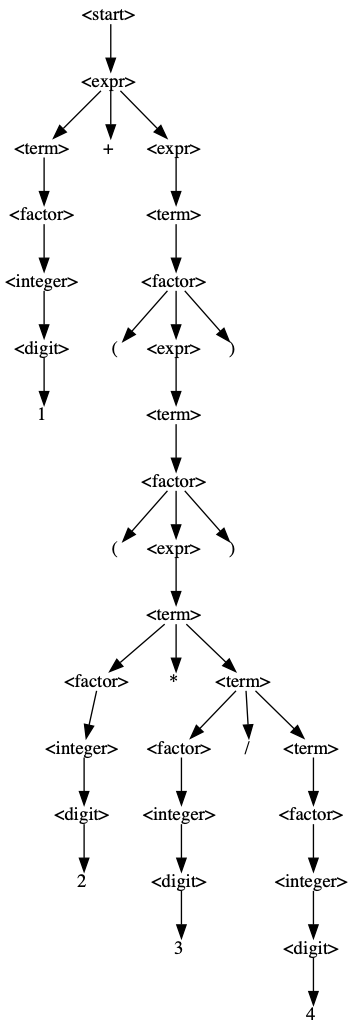

In [15]:
zoom(display_tree(parsed_expr))

#### A Fuzzer

In order to define abstraction, we need to be able to generate values based on a grammar. Our fuzzer is able to do that.

In [16]:
import random

##### The interface

In [17]:
class Fuzzer:
    def __init__(self, grammar):
        self.grammar = grammar

    def fuzz(self, key='<start>', max_num=None, max_depth=None):
        raise NotImplemented()

##### The implementation

The fuzzer tries to randomly choose an expansion when more than one expansion is available. If however, it goes beyond max_depth, then it chooses the cheapest nodes. The cheapest nodes are those nodes with minimum further expansion (no recursion).

In [18]:
class LimitFuzzer(Fuzzer):
    def symbol_cost(self, grammar, symbol, seen):
        if symbol in self.key_cost: return self.key_cost[symbol]
        if symbol in seen:
            self.key_cost[symbol] = float('inf')
            return float('inf')
        v = min((self.expansion_cost(grammar, rule, seen | {symbol})
                    for rule in grammar.get(symbol, [])), default=0)
        self.key_cost[symbol] = v
        return v

    def expansion_cost(self, grammar, tokens, seen):
        return max((self.symbol_cost(grammar, token, seen)
                    for token in tokens if token in grammar), default=0) + 1

    def gen_key(self, key, depth, max_depth):
        if key not in self.grammar: return key
        if depth > max_depth:
            assert key in self.cost
            clst = sorted([(self.cost[key][str(rule)], rule) for rule in self.grammar[key]])
            rules = [r for c,r in clst if c == clst[0][0]]
        else:
            rules = self.grammar[key]
        return self.gen_rule(random.choice(rules), depth+1, max_depth)

    def gen_rule(self, rule, depth, max_depth):
        return ''.join(self.gen_key(token, depth, max_depth) for token in rule)

    def fuzz(self, key='<start>', max_depth=10):
        return self.gen_key(key=key, depth=0, max_depth=max_depth)

    def __init__(self, grammar):
        super().__init__(grammar)
        self.key_cost = {}
        self.cost = self.compute_cost(grammar)

    def compute_cost(self, grammar):
        cost = {}
        for k in grammar:
            cost[k] = {}
            for rule in grammar[k]:
                cost[k][str(rule)] = self.expansion_cost(grammar, rule, set())
        return cost

In [19]:
expr_fuzzer = LimitFuzzer(EXPR_GRAMMAR)
expr_fuzzer.fuzz()

'+3 / -+3'

### Library functions

Finding nodes given the path

In [20]:
def find_node(node, path):
    name, children, *rest = node
    if not path:
        return node
    p, *path = path
    for i,c in enumerate(children):
        if i == p:
            return find_node(c, path)
    return None

In [21]:
find_node(parsed_expr, [0,1])

(' + ', [])

In [22]:
find_node(parsed_expr, [0,2,0,0,2])

(')', [])

In the grammar, we want to compute the minimum/maximum possible expansions for each nontermainal. The reason is that, if the number of expansions is limited (1) then, marking the parent for generalization does not get us anything. For parents with those nonterminals (honorary terminals), we register their grand parent.

In [23]:
import math

In [24]:
def find_maximum_expansions_for_key(grammar, key, seen_so_far):
    child_expansions = 0
    
    for rule in grammar[key]:
        rule_expansions = 1
        for token in rule:
            if token in seen_so_far:
                return math.inf
            if not is_nt(token):
                # only a single expansion
                rule_expansions *= 1
            else:
                v = find_maximum_expansions_for_key(grammar, token, seen_so_far | {key})
                rule_expansions *= v
        child_expansions += rule_expansions
    return child_expansions

In [25]:
def find_maximum_expansions(grammar):
    return {k:find_maximum_expansions_for_key(grammar, k, set()) for k in grammar}

In [26]:
find_maximum_expansions(EXPR_GRAMMAR)

{'<start>': inf,
 '<expr>': inf,
 '<term>': inf,
 '<factor>': inf,
 '<integer>': inf,
 '<digit>': 10}

First, collect the paths to the (unique) parents of each terminal symbol, then extend it by paths to the unique parents of each nonterminal that does not have enough expansions. From this, generate abstract trees with the particular node marked abstract.

Next, identify recursive nonterminals in the grammar. Identify nodes that are parents of terminal symbols that are recursive. Finally, generate new trees with these recursive nodes replaced by any of their closest chidren of same kind.


In [27]:
def find_matching_node_subpaths(node, fn):
    name, children = node
    if fn(node): return [[]]
    paths = []
    for i,c in enumerate(children):
        ps_ = find_matching_node_subpaths(c, fn)
        if ps_:
            ps = [[i] + p_ for p_ in ps_]
            paths.extend(ps)
    return paths

In [28]:
def match_factor(n):
    return n[0] == '<factor>'

In [29]:
paths = find_matching_node_subpaths(parsed_expr, match_factor)
for p in paths:
    print(p)
    n = find_node(parsed_expr, p)
    print(n[0], tree_to_str(n))

[0, 0, 0]
<factor> 1
[0, 2, 0, 0]
<factor> ((2 * 3 / 4))


In [30]:
def replace_tree(node, path, newnode):
    if not path:
        return newnode
    name, children = node
    hd, *subpath = path
    assert hd < len(children)
    new_children = []
    for i,c in enumerate(children):
        if i == hd:
            c_ = replace_tree(c, subpath, newnode)
        else:
            c_ = c
        new_children.append(c_)
    return (name, new_children)

In [31]:
tree_to_str(find_node(parsed_expr, [0,2,0,0]))

'((2 * 3 / 4))'

In [32]:
tree_to_str(replace_tree(parsed_expr, [0, 2, 0, 0], ('1', [])))

'1 + 1'

Validating a parse tree

In [33]:
def validate_tree(tree, grammar):
    def keys(arr):
        return [a[0] for a in arr]
    name, children, *rest = tree
    if not is_nt(name): return True
    
    seen = False
    for rule in grammar[name]:
        if keys(children) == rule:
            seen = True
    assert seen, name + ' needs ' + repr(grammar[name])
    for c in children:
        validate_tree(c, grammar)

In [34]:
validate_tree(parsed_expr, EXPR_GRAMMAR)

In [35]:
try:
    validate_tree(replace_tree(parsed_expr, [0, 2, 0, 0], ('1', [])), EXPR_GRAMMAR)
except AssertionError as e:
    print(e)

<term> needs [['<factor>', ' * ', '<term>'], ['<factor>', ' / ', '<term>'], ['<factor>']]


In [36]:
rt = replace_tree(parsed_expr, [0, 2, 0, 0], ('<factor>', [('<integer>', [('<digit>',[('1', [])])])]))
try:
    validate_tree(rt, EXPR_GRAMMAR)
except AssertionError as e:
    print(e)

In [37]:
tree_to_str(rt)

'1 + 1'

In [38]:
def grammar_gc(grammar, start_symbol):
    def strip_key(grammar, key, order):
        rules = sorted(grammar[key])
        old_len = len(order)
        for rule in rules:
            for token in rule:
                if is_nt(token):
                    if token not in order:
                        order.append(token)
        new = order[old_len:]
        for ckey in new:
            strip_key(grammar, ckey, order)
    if start_symbol not in grammar:
        return {}

    order = [start_symbol]
    strip_key(grammar, start_symbol, order)
    if len(order) != len(grammar.keys()):
        stripped = [k for k in grammar if k not in order]
        if stripped:
            print("Stripping: %s" % str(stripped))
        faulty = [k for k in order if k not in grammar]
        assert not faulty
    return {k: [list(r) for r in sorted(grammar[k])] for k in order}

## Contextualization

The output that we get from `ddset` has nodes marked. So, we define a way to mark nodes as abstract.

### Mark the abstract nodes

Given a path, we mark the node as abstract.

In [39]:
def mark_path_abstract(tree, path):
    name, children = find_node(tree, path)
    new_tree = replace_tree(tree, path, (name, children, {'abstract': True}))
    return new_tree

First, we locate a suitable node.

In [40]:
abs_path_1 = [0,2,0,0,1,0,0,1]
tree_to_str(find_node(parsed_expr, abs_path_1))

'2 * 3 / 4'

In [41]:
v = mark_path_abstract(parsed_expr, abs_path_1); v

('<start>',
 [('<expr>',
   [('<term>', [('<factor>', [('<integer>', [('<digit>', [('1', [])])])])]),
    (' + ', []),
    ('<expr>',
     [('<term>',
       [('<factor>',
         [('(', []),
          ('<expr>',
           [('<term>',
             [('<factor>',
               [('(', []),
                ('<expr>',
                 [('<term>',
                   [('<factor>', [('<integer>', [('<digit>', [('2', [])])])]),
                    (' * ', []),
                    ('<term>',
                     [('<factor>',
                       [('<integer>', [('<digit>', [('3', [])])])]),
                      (' / ', []),
                      ('<term>',
                       [('<factor>',
                         [('<integer>', [('<digit>', [('4', [])])])])])])])],
                 {'abstract': True}),
                (')', [])])])]),
          (')', [])])])])])])

Given a tree with some nodes marked abstract, go through the tree, and mark everything else as concrete. Default is to mark a node as concrete.

In [42]:
def mark_concrete_r(tree):
    name, children, *abstract_a = tree
    abstract = {'abstract': False} if not abstract_a else abstract_a[0]
    return (name, [mark_concrete_r(c) for c in children], abstract)

In [43]:
t = mark_concrete_r(v); t

('<start>',
 [('<expr>',
   [('<term>',
     [('<factor>',
       [('<integer>',
         [('<digit>', [('1', [], {'abstract': False})], {'abstract': False})],
         {'abstract': False})],
       {'abstract': False})],
     {'abstract': False}),
    (' + ', [], {'abstract': False}),
    ('<expr>',
     [('<term>',
       [('<factor>',
         [('(', [], {'abstract': False}),
          ('<expr>',
           [('<term>',
             [('<factor>',
               [('(', [], {'abstract': False}),
                ('<expr>',
                 [('<term>',
                   [('<factor>',
                     [('<integer>',
                       [('<digit>',
                         [('2', [], {'abstract': False})],
                         {'abstract': False})],
                       {'abstract': False})],
                     {'abstract': False}),
                    (' * ', [], {'abstract': False}),
                    ('<term>',
                     [('<factor>',
                      

A way to display the abstracted tree

In [44]:
def till_abstract(node):
    name, children, *rest = node
    if rest[-1]['abstract']:
        return (name + '*', [])
    return (name, [till_abstract(c) for c in children], *rest)

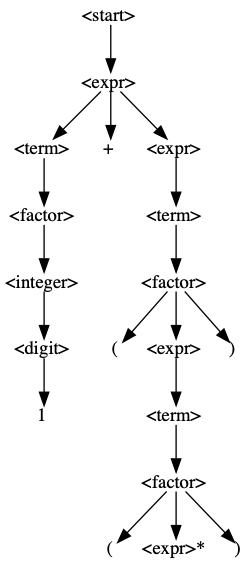

In [45]:
zoom(display_tree(till_abstract(t)))

In [46]:
abs_t1_ = find_node(parsed_expr, [0, 2])
tree_to_str(abs_t1_), abs_t1_[0]

('((2 * 3 / 4))', '<expr>')

In [47]:
abs_t1 = ('<start>', [abs_t1_])

In [48]:
validate_tree(abs_t1, EXPR_GRAMMAR)

In [49]:
t_abs_p1 = [0, 0, 0, 1, 0, 0, 1]
Ts(find_node(abs_t1, t_abs_p1))

'2 * 3 / 4'

We now define a function to check if a given node is abstract or not.

In [50]:
def e_g_(abstract_a):
    if not abstract_a:
        return True
    else:
        return abstract_a[0]['abstract']

In [51]:
def is_node_abstract(node):
    name, children, *abstract_a = node
    if not abstract_a:
        return True
    else:
        return abstract_a[0]['abstract']

In [52]:
def tree_to_str_a(tree):
    name, children, *general_ = tree
    if not is_nt(name): return name
    if is_node_abstract(tree):
        return name
    return ''.join([tree_to_str_a(c) for c in children])

In [53]:
Ta = tree_to_str_a

In [54]:
tree_to_str_a(t)

'1 + ((<expr>))'

In [55]:
abs_tree1 = mark_concrete_r(mark_path_abstract(abs_t1, t_abs_p1)); abs_tree1

('<start>',
 [('<expr>',
   [('<term>',
     [('<factor>',
       [('(', [], {'abstract': False}),
        ('<expr>',
         [('<term>',
           [('<factor>',
             [('(', [], {'abstract': False}),
              ('<expr>',
               [('<term>',
                 [('<factor>',
                   [('<integer>',
                     [('<digit>',
                       [('2', [], {'abstract': False})],
                       {'abstract': False})],
                     {'abstract': False})],
                   {'abstract': False}),
                  (' * ', [], {'abstract': False}),
                  ('<term>',
                   [('<factor>',
                     [('<integer>',
                       [('<digit>',
                         [('3', [], {'abstract': False})],
                         {'abstract': False})],
                       {'abstract': False})],
                     {'abstract': False}),
                    (' / ', [], {'abstract': False}),
               

In [56]:
Ta(abs_tree1)

'((<expr>))'

In [57]:
def mark_abstract_nodes(tree, paths):
    for path in paths:
        tree = mark_path_abstract(tree, path)
    return mark_concrete_r(tree)

In [58]:
Ta(mark_abstract_nodes(abs_t1, []))

'((2 * 3 / 4))'

In [59]:
Ta(mark_abstract_nodes(abs_t1, [t_abs_p1]))

'((<expr>))'

### Finding characterizing node

A characterizing node is the lowest node that completely contains the given pattern.

In [60]:
 def find_charecterizing_node(tree):
    name, children, gen = tree
    if len(children) == 1:
        return find_charecterizing_node(children[0])
    return tree

In [61]:
abs_tree_cnode1 = find_charecterizing_node(abs_tree1); abs_tree_cnode1

('<factor>',
 [('(', [], {'abstract': False}),
  ('<expr>',
   [('<term>',
     [('<factor>',
       [('(', [], {'abstract': False}),
        ('<expr>',
         [('<term>',
           [('<factor>',
             [('<integer>',
               [('<digit>',
                 [('2', [], {'abstract': False})],
                 {'abstract': False})],
               {'abstract': False})],
             {'abstract': False}),
            (' * ', [], {'abstract': False}),
            ('<term>',
             [('<factor>',
               [('<integer>',
                 [('<digit>',
                   [('3', [], {'abstract': False})],
                   {'abstract': False})],
                 {'abstract': False})],
               {'abstract': False}),
              (' / ', [], {'abstract': False}),
              ('<term>',
               [('<factor>',
                 [('<integer>',
                   [('<digit>',
                     [('4', [], {'abstract': False})],
                     {'abstract'

As can be seen, the `<factor>` node completely contains the fault pattern.

In [62]:
abs_tree1[0], Ts(abs_tree1)

('<start>', '((2 * 3 / 4))')

In [63]:
abs_tree_cnode1[0], Ts(abs_tree_cnode1)

('<factor>', '((2 * 3 / 4))')

### Finding reachable keys

In [64]:
def find_reachable_keys(grammar, key, reachable_keys=None, found_so_far=None):
    if reachable_keys is None: reachable_keys = {}
    if found_so_far is None: found_so_far = set()

    for rule in grammar[key]:
        for token in rule:
            if not is_nt(token): continue
            if token in found_so_far: continue
            found_so_far.add(token)
            if token in reachable_keys:
                for k in reachable_keys[token]:
                    found_so_far.add(k)
            else:
                keys = find_reachable_keys(grammar, token, reachable_keys, found_so_far)
                # reachable_keys[token] = keys <- found_so_far contains results from earlier
    return found_so_far

In [65]:
for key in EXPR_GRAMMAR:
    keys = find_reachable_keys(EXPR_GRAMMAR, key, {})
    print(key, keys)

<start> {'<term>', '<integer>', '<expr>', '<digit>', '<factor>'}
<expr> {'<term>', '<integer>', '<expr>', '<digit>', '<factor>'}
<term> {'<term>', '<integer>', '<expr>', '<digit>', '<factor>'}
<factor> {'<term>', '<integer>', '<expr>', '<digit>', '<factor>'}
<integer> {'<digit>', '<integer>'}
<digit> set()


Finding recursive keys

In [66]:
def reachable_dict(grammar):
    reachable = {}
    for key in grammar:
        keys = find_reachable_keys(grammar, key, reachable)
        reachable[key] = keys
    return reachable

In [67]:
reachable_dict(EXPR_GRAMMAR)

{'<start>': {'<digit>', '<expr>', '<factor>', '<integer>', '<term>'},
 '<expr>': {'<digit>', '<expr>', '<factor>', '<integer>', '<term>'},
 '<term>': {'<digit>', '<expr>', '<factor>', '<integer>', '<term>'},
 '<factor>': {'<digit>', '<expr>', '<factor>', '<integer>', '<term>'},
 '<integer>': {'<digit>', '<integer>'},
 '<digit>': set()}

### Updating the grammar with failure keys

Now, we want to add our grammar the keys that are required to cause a failure. For that, we first extract the local grammar that reproduces the fault pattern 

#### Linear Grammar

In [68]:
abs_tree_cnode1

('<factor>',
 [('(', [], {'abstract': False}),
  ('<expr>',
   [('<term>',
     [('<factor>',
       [('(', [], {'abstract': False}),
        ('<expr>',
         [('<term>',
           [('<factor>',
             [('<integer>',
               [('<digit>',
                 [('2', [], {'abstract': False})],
                 {'abstract': False})],
               {'abstract': False})],
             {'abstract': False}),
            (' * ', [], {'abstract': False}),
            ('<term>',
             [('<factor>',
               [('<integer>',
                 [('<digit>',
                   [('3', [], {'abstract': False})],
                   {'abstract': False})],
                 {'abstract': False})],
               {'abstract': False}),
              (' / ', [], {'abstract': False}),
              ('<term>',
               [('<factor>',
                 [('<integer>',
                   [('<digit>',
                     [('4', [], {'abstract': False})],
                     {'abstract'

In [69]:
 def mark_faulty_name(symbol, prefix, v):
    return '<%s L%s_%s>'% (symbol[1:-1], prefix, v)

In [70]:
def mark_faulty_nodes(node, prefix, counter=None):
    if counter is None: counter = {}
    symbol, children, *abstract = node
    if is_node_abstract(node): # we dont markup further
        return node
    if symbol not in counter: counter[symbol] = 0
    counter[symbol] += 1
    v = str(counter[symbol])
    if is_nt(symbol):
        return (mark_faulty_name(symbol, prefix, v),
                [mark_faulty_nodes(c, prefix, counter) for c in children],
                *abstract)
    else:
        assert not children
        return (symbol, children, *abstract)

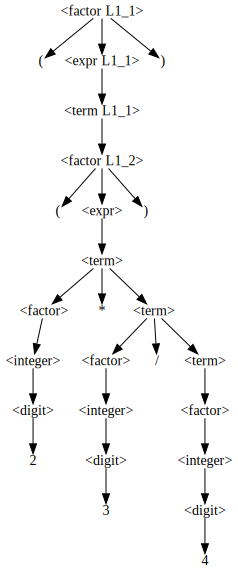

In [71]:
display_tree(mark_faulty_nodes(abs_tree_cnode1, '1'))

In [72]:
c_node1 = mark_faulty_nodes(abs_tree_cnode1, '1')

In [73]:
f_node1 = c_node1

In [74]:
def faulty_node_to_grammar(tree, grammar=None):
    if grammar is None: grammar = {}
    if is_node_abstract(tree): return grammar
    name, children, *rest = tree
    tokens = []
    if name not in grammar: grammar[name] = []
    for c in children:
        n, cs, *rest = c
        tokens.append(n)
        if is_nt(n):
            faulty_node_to_grammar(c, grammar)
    grammar[name].append(tuple(tokens))
    return grammar

In [75]:
faulty_node_to_grammar(abs_tree_cnode1)

{'<factor>': [('(', '<expr>', ')'), ('(', '<expr>', ')')],
 '<expr>': [('<term>',)],
 '<term>': [('<factor>',)]}

In [76]:
def faulty_node_to_linear_grammar(tree, prefix, grammar=None):
    ltree = mark_faulty_nodes(tree, prefix)
    return faulty_node_to_grammar(ltree)

In [77]:
faulty_node_to_linear_grammar(abs_tree_cnode1, '1')

{'<factor L1_1>': [('(', '<expr L1_1>', ')')],
 '<expr L1_1>': [('<term L1_1>',)],
 '<term L1_1>': [('<factor L1_2>',)],
 '<factor L1_2>': [('(', '<expr>', ')')]}

In [78]:
dd_tree_abs1 = abs_tree1

In [79]:
faulty_node1 = abs_tree_cnode1

### Finding insertable positions

Given a rule, and the faulty symbol, the positions in the rule where the fault can be inserted are all the non-terminals that will eventually reach the symbol of the faulty symbol. That is, if we have `<digit> + <expr>` as the expansion and the faulty symbol is `<factor*>` then, since `<digit>` can never reach `<factor>`, `0` is out, and so is `1` since it is a terminal symbol. Hence, only `<expr>` remains, which when expanded, one of the expansion paths will include a `<factor>`. Hence, here `[2]` is the answer.

In [80]:
def get_insertable_positions(rule, fkey, reachable):
    positions = []
    for i, token in enumerate(rule):
        if not is_nt(token): continue
        if fkey in reachable[token]:
            positions.append(i)
    return positions

In [81]:
reachable1 = reachable_dict(EXPR_GRAMMAR)

In [82]:
for k in EXPR_GRAMMAR:
    print(k)
    for rule in EXPR_GRAMMAR[k]:
        v = get_insertable_positions(rule, '<factor>', reachable1)
        print('\t', rule, v)

<start>
	 ['<expr>'] [0]
<expr>
	 ['<term>', ' + ', '<expr>'] [0, 2]
	 ['<term>', ' - ', '<expr>'] [0, 2]
	 ['<term>'] [0]
<term>
	 ['<factor>', ' * ', '<term>'] [0, 2]
	 ['<factor>', ' / ', '<term>'] [0, 2]
	 ['<factor>'] [0]
<factor>
	 ['+', '<factor>'] [1]
	 ['-', '<factor>'] [1]
	 ['(', '<expr>', ')'] [1]
	 ['<integer>', '.', '<integer>'] []
	 ['<integer>'] []
<integer>
	 ['<digit>', '<integer>'] []
	 ['<digit>'] []
<digit>
	 ['0'] []
	 ['1'] []
	 ['2'] []
	 ['3'] []
	 ['4'] []
	 ['5'] []
	 ['6'] []
	 ['7'] []
	 ['8'] []
	 ['9'] []


### Insert into key definition

The essential idea is to make the rules in the grammar such that there is one fault position in each position.
Take one rule at a time. For each token in the rule, get the reachable tokens. If the fsym is not in reachable tokens, then the falt can nnot be inserted in that position. So get all positions for the rule that we can insert fsym in, and for each position, change the symbol for later insertion.

In [83]:
def to_faulty_key(name, prefix):
    return "<%s F%s>" % (name[1:-1], prefix)

In [84]:
def insert_into_key(grammar, key, fsym, prefix, reachable):
    rules = grammar[key]
    my_rules = []
    for rule in grammar[key]:
        positions = get_insertable_positions(rule, fsym, reachable)
        if not positions: # make it len(positions) >= n if necessary
            # skip this rule because we can not embed the fault here.
            continue
        else:
            # at each position, insert the fsym
            for pos in positions:
                new_rule = list(copy.deepcopy(rule))
                new_rule[pos] = to_faulty_key(new_rule[pos], prefix)
                my_rules.append(new_rule)
    return (to_faulty_key(key, prefix), my_rules)

In [85]:
for key in EXPR_GRAMMAR:
    fk, rules = insert_into_key(EXPR_GRAMMAR, key, '<factor>', '1', reachable1)
    print(fk)
    for r in rules:
        print('    ', r)
    print()

<start F1>
     ['<expr F1>']

<expr F1>
     ['<term F1>', ' + ', '<expr>']
     ['<term>', ' + ', '<expr F1>']
     ['<term F1>', ' - ', '<expr>']
     ['<term>', ' - ', '<expr F1>']
     ['<term F1>']

<term F1>
     ['<factor F1>', ' * ', '<term>']
     ['<factor>', ' * ', '<term F1>']
     ['<factor F1>', ' / ', '<term>']
     ['<factor>', ' / ', '<term F1>']
     ['<factor F1>']

<factor F1>
     ['+', '<factor F1>']
     ['-', '<factor F1>']
     ['(', '<expr F1>', ')']

<integer F1>

<digit F1>



In [86]:
def remove_duplicate_rules(grammar):
    return {k: list(set([tuple(rule) for rule in grammar[k]])) for k in grammar}

In [87]:
def insert_into_grammar(grammar, new_grammar, fsym, prefix_f, reachable):
    for key in grammar:
        fk, rules = insert_into_key(grammar, key, fsym, prefix_f, reachable)
        if not rules: continue # no applicable rules
        if fk not in new_grammar:
            new_grammar[fk] = []
        new_grammar[fk].extend(rules)
    return remove_duplicate_rules(new_grammar)

### Get the final grammar

The final steps are as follows:
1. Add the fault node, and the child nodes to the grammar.
2. Generate the faulty key definitions. This is done per key in the original grammar.
3. Finally, connect the faulty key and fault node.

In [88]:
def get_faulty_grammar(grammar, start_symbol, fault_node, f_idx):
    def L_prefix(i): return '%d' % i
    def F_prefix(i): return '%d' % i
    prefix_l = L_prefix(f_idx)
    prefix_f = F_prefix(f_idx)
    key_f = fault_node[0]
    # First, get the linear grammar

    g = faulty_node_to_linear_grammar(fault_node, prefix_l)
    new_grammar = {**g, **grammar}
    
    reachable = reachable_dict(grammar)
    # the new grammar contains the faulty keys and their definitions.
    # next, want to insert the fault prefix_f into each insertable positions. 
    # the insertable locations are those that can reach fsym
    insert_into_grammar(grammar, new_grammar, key_f, prefix_f, reachable)

    # now, the faulty key is an alternative to the original
    fkey = mark_faulty_name(key_f, prefix_l, 1) # the starting in make_faulty is 1
    fsym = to_faulty_key(key_f, prefix_f)
    new_grammar[fsym].append([fkey])
        
    return to_faulty_key(start_symbol, F_prefix(f_idx)), new_grammar

In [89]:
start_faulty1, faulty_grammar1 = get_faulty_grammar(EXPR_GRAMMAR, '<start>', faulty_node1, 1); faulty_grammar1

{'<factor L1_1>': [('(', '<expr L1_1>', ')')],
 '<expr L1_1>': [('<term L1_1>',)],
 '<term L1_1>': [('<factor L1_2>',)],
 '<factor L1_2>': [('(', '<expr>', ')')],
 '<start>': [['<expr>']],
 '<expr>': [['<term>', ' + ', '<expr>'],
  ['<term>', ' - ', '<expr>'],
  ['<term>']],
 '<term>': [['<factor>', ' * ', '<term>'],
  ['<factor>', ' / ', '<term>'],
  ['<factor>']],
 '<factor>': [['+', '<factor>'],
  ['-', '<factor>'],
  ['(', '<expr>', ')'],
  ['<integer>', '.', '<integer>'],
  ['<integer>']],
 '<integer>': [['<digit>', '<integer>'], ['<digit>']],
 '<digit>': [['0'],
  ['1'],
  ['2'],
  ['3'],
  ['4'],
  ['5'],
  ['6'],
  ['7'],
  ['8'],
  ['9']],
 '<start F1>': [['<expr F1>']],
 '<expr F1>': [['<term F1>', ' + ', '<expr>'],
  ['<term>', ' + ', '<expr F1>'],
  ['<term F1>', ' - ', '<expr>'],
  ['<term>', ' - ', '<expr F1>'],
  ['<term F1>']],
 '<term F1>': [['<factor F1>', ' * ', '<term>'],
  ['<factor>', ' * ', '<term F1>'],
  ['<factor F1>', ' / ', '<term>'],
  ['<factor>', ' / ', '

In [90]:
start_faulty1

'<start F1>'

In [91]:
gf1 = LimitFuzzer(faulty_grammar1)
parser1 = Parser(faulty_grammar1, canonical=True, start_symbol=start_faulty1)

In [92]:
for i in range(10):
    s = gf1.fuzz(key=start_faulty1)
    for t in parser1.parse(s):
        print(tree_to_str(t))
    print()

02648.9 / ++(0 / 5 / ((9.3)) * 0.2 - +8.1 / 0) + (+(1.3 / 8.3 + 4.6 - 3) / (9 / 1.6) * +(0) * 0.7 - -++1 * +4.1 * 5 / 8.9 + +3.3 * 2 + 7 / 2 + 1.7 + 6 + 6) * 2 / ---16 * 23 / -+1.7 / 20 * 1 * 8.3

6 + --2 * +-8 * 8.75 / 11.09 * +7 + -+(+3.8 / 7 * 1.0 - 9 / 0.8) - (9.4 / 0.8) / ((7.6)) / (6.4 / 5.9) / 99 + ((4.1)) / -8.1 / 9.19 / (6.0) / 1.8 / 6

+(+(1.3 + 0.1) / 77 / 6 / -4 / 5 * 6.9 - --+7.3 * 3.81 * +0 + 0.50 - 8.9 / 5.4 - 5 / 1.3 - 2.4 - 5) * (+(3.7 * 4.0 + 8.5 + 4) * 96.7 * (((5.7)) * 0.0 - 2.9) * 7.7 * 4 / 5.7 - -8 / ++5 * +7 + --2.8) / 6702.3 * 50.3 / +8 / -++6.3 / --7 * 5 * 4.3 * 6

+(+-+-6 * -++9.2 / +(0) + 6) - (07 / --(((4.0)) * 6) - 324.579 * (4.5) + +-1.1 - -8 / 3 * 6 + 6.4 * 2) / ++1 + +9.97 - (-(7) + 4 * 7.4 / 4.3 + 7 / 3 - 4) / 43 / 4 + +691 / 9.4 + (3 / 6) / 3.2 * -7.4 / 8 / 3.2 + +(1) / 6.4 + (8)

+-4961.8 - 2.43 * 589 / --++(4.6) - 9.022716 * 5 * ---1 / (7 / 7.4 - 8.1) * +-5 * +6 / 7 / 8 - (+(((2)) / 5.5 - 2) + (0.0) / 7 * 1) - (7 - 2.5) * --+1 + 97 + -+3.3 * +6 + +0.

A few parses

In [93]:
for tree in parser1.parse('((2))'):
    print(tree_to_str(tree))

((2))


In [94]:
for tree in parser1.parse('((1 + 1))'):
    print(tree_to_str(tree))

((1 + 1))


In [95]:
try:
    for tree in parser1.parse('1 + 2'):
        print(tree)
except SyntaxError as e:
    print(e)

at '1 + 2'


In [96]:
for tree in parser1.parse('1 + ((3))'):
    print(tree_to_str(tree))

1 + ((3))


## Adding Another Fault

In [97]:
f2_grammar = grammar_gc(faulty_grammar1, start_faulty1); f2_grammar

Stripping: ['<start>']


{'<start F1>': [['<expr F1>']],
 '<expr F1>': [['<term F1>'],
  ['<term F1>', ' + ', '<expr>'],
  ['<term F1>', ' - ', '<expr>'],
  ['<term>', ' + ', '<expr F1>'],
  ['<term>', ' - ', '<expr F1>']],
 '<term F1>': [['<factor F1>'],
  ['<factor F1>', ' * ', '<term>'],
  ['<factor F1>', ' / ', '<term>'],
  ['<factor>', ' * ', '<term F1>'],
  ['<factor>', ' / ', '<term F1>']],
 '<expr>': [['<term>'],
  ['<term>', ' + ', '<expr>'],
  ['<term>', ' - ', '<expr>']],
 '<term>': [['<factor>'],
  ['<factor>', ' * ', '<term>'],
  ['<factor>', ' / ', '<term>']],
 '<factor F1>': [['(', '<expr F1>', ')'],
  ['+', '<factor F1>'],
  ['-', '<factor F1>'],
  ['<factor L1_1>']],
 '<factor>': [['(', '<expr>', ')'],
  ['+', '<factor>'],
  ['-', '<factor>'],
  ['<integer>'],
  ['<integer>', '.', '<integer>']],
 '<factor L1_1>': [['(', '<expr L1_1>', ')']],
 '<expr L1_1>': [['<term L1_1>']],
 '<term L1_1>': [['<factor L1_2>']],
 '<factor L1_2>': [['(', '<expr>', ')']],
 '<integer>': [['<digit>'], ['<digit>', 

### Abstract nodes

In [98]:
abs_path_2 = [0, 2, 0, 0, 1, 0, 0, 1, 0, 2]
tree2 = find_node(parsed_expr, abs_path_2)

In [99]:
tree2

('<term>',
 [('<factor>', [('<integer>', [('<digit>', [('3', [])])])]),
  (' / ', []),
  ('<term>', [('<factor>', [('<integer>', [('<digit>', [('4', [])])])])])])

In [100]:
find_node(tree2, [2])

('<term>', [('<factor>', [('<integer>', [('<digit>', [('4', [])])])])])

In [101]:
abs_tree2 = mark_abstract_nodes(tree2, [[0], [2]])

In [102]:
tree_to_str_a(abs_tree2)

'<factor> / <term>'

In [103]:
abs_tree2

('<term>',
 [('<factor>',
   [('<integer>',
     [('<digit>', [('3', [], {'abstract': False})], {'abstract': False})],
     {'abstract': False})],
   {'abstract': True}),
  (' / ', [], {'abstract': False}),
  ('<term>',
   [('<factor>',
     [('<integer>',
       [('<digit>', [('4', [], {'abstract': False})], {'abstract': False})],
       {'abstract': False})],
     {'abstract': False})],
   {'abstract': True})],
 {'abstract': False})

### Characterizing node

In [104]:
abs_tree_cnode2 = find_charecterizing_node(abs_tree2); abs_tree_cnode2

('<term>',
 [('<factor>',
   [('<integer>',
     [('<digit>', [('3', [], {'abstract': False})], {'abstract': False})],
     {'abstract': False})],
   {'abstract': True}),
  (' / ', [], {'abstract': False}),
  ('<term>',
   [('<factor>',
     [('<integer>',
       [('<digit>', [('4', [], {'abstract': False})], {'abstract': False})],
       {'abstract': False})],
     {'abstract': False})],
   {'abstract': True})],
 {'abstract': False})

In [105]:
c_node2 = mark_faulty_nodes(abs_tree_cnode2, '2'); c_node2

('<term L2_1>',
 [('<factor>',
   [('<integer>',
     [('<digit>', [('3', [], {'abstract': False})], {'abstract': False})],
     {'abstract': False})],
   {'abstract': True}),
  (' / ', [], {'abstract': False}),
  ('<term>',
   [('<factor>',
     [('<integer>',
       [('<digit>', [('4', [], {'abstract': False})], {'abstract': False})],
       {'abstract': False})],
     {'abstract': False})],
   {'abstract': True})],
 {'abstract': False})

### Reachable keys

Next, we need to identify insertable positions. The complexity here is that we have some special nodes -- `L` and `F` that require special handling. For these, only the first part of the nt should be inspected. Note that the `L` node is the linearized fault pattern, while `F` is the guaranteed fault nonterminal.

Simple reachability analysis works for all nodes;

 However, simple reachability is not enough. We also have to check whether `L` nodes match directly, and if so, add them to reachable.

First, we find all the `L` keys, then, choose only those keys that correspond to the characteristic node of our fault. Only these can be inspected for direct match.

In [106]:
def is_linear(key): return ' L' in key

In [107]:
def normalize(key):
    assert key[0], key[-1] == ('<', '>')
    return '<%s>' % key[1:-1].split()[0]

In [108]:
nt_name2 = abs_tree_cnode2[0]; nt_name2

'<term>'

In [109]:
L0 = [key for key in f2_grammar if is_linear(key) and normalize(key) == '<factor>']; L0

['<factor L1_1>', '<factor L1_2>']

In [110]:
L1 = [key for key in f2_grammar if is_linear(key) and normalize(key) == nt_name2]; L1

['<term L1_1>']

How many of the above list will match our new fault pattern directly? Note that we are not interested in indirect matches as they will be included in the reachable dict anyway.

In [111]:
def node_to_normalized_rule(children):
    return [normalize(c[0]) if is_nt(c[0]) else c[0] for c in children]

In [112]:
def rule_to_normalized_rule(rule):
    return [normalize(t) if is_nt(t) else t for t in rule]

In [113]:
def to_non_faulty_key(name, prefix):
    return "<%s N%s>" % (name[1:-1], prefix)

In [114]:
[c[0] for c in c_node1[1]]

['(', '<expr L1_1>', ')']

In [115]:
node_to_normalized_rule(c_node1[1])

['(', '<expr>', ')']

In [116]:
c_node1

('<factor L1_1>',
 [('(', [], {'abstract': False}),
  ('<expr L1_1>',
   [('<term L1_1>',
     [('<factor L1_2>',
       [('(', [], {'abstract': False}),
        ('<expr>',
         [('<term>',
           [('<factor>',
             [('<integer>',
               [('<digit>',
                 [('2', [], {'abstract': False})],
                 {'abstract': False})],
               {'abstract': False})],
             {'abstract': False}),
            (' * ', [], {'abstract': False}),
            ('<term>',
             [('<factor>',
               [('<integer>',
                 [('<digit>',
                   [('3', [], {'abstract': False})],
                   {'abstract': False})],
                 {'abstract': False})],
               {'abstract': False}),
              (' / ', [], {'abstract': False}),
              ('<term>',
               [('<factor>',
                 [('<integer>',
                   [('<digit>',
                     [('4', [], {'abstract': False})],
            

In [117]:
c_node2

('<term L2_1>',
 [('<factor>',
   [('<integer>',
     [('<digit>', [('3', [], {'abstract': False})], {'abstract': False})],
     {'abstract': False})],
   {'abstract': True}),
  (' / ', [], {'abstract': False}),
  ('<term>',
   [('<factor>',
     [('<integer>',
       [('<digit>', [('4', [], {'abstract': False})], {'abstract': False})],
       {'abstract': False})],
     {'abstract': False})],
   {'abstract': True})],
 {'abstract': False})

TODO: There are two things to be careful about here: The new cnode could be more refined than the original: i.e new cnode is `(((<expr>)))` and the grammar represents `((<expr>))` or the new cnode could be more abstract: `(<expr>)`. Note that while grammar can present `((<expr ...>))`, cnode can never present `(<expr ...>)`. Unfortunately, these could be different on each abstract node, which could be many in the same cnode. These are not problematic in `f1 and f2` operations as we do not guarantee exact count, but should be handled in `f1 and not(f2)`.

In [118]:
def does_Lkey_produce_abs_pattern(grammar, key, cnode):
    name_c, children_c, *rest = cnode
    #assert ' ' not in name_c # not on marked cnodes
    rule_c = node_to_normalized_rule(children_c)
    nkey = normalize(key)
    if normalize(name_c) != nkey:
        return False
    if is_node_abstract(cnode): # we do not need to check anymore.
        # TODO: is the grammar more refined?
        return True
    
    # a not abstract key should be linear.
    if not is_linear(key):
        # TODO: is the cnode more refined?
        return False
    # print(key, 'matches', name_c)

    rules = grammar[key]
    for rule in rules:
        match = False
        n_rule = [normalize(t) if is_nt(t) else t for t in rule]
        if n_rule != rule_c: continue
        for k,c in zip(rule, children_c):
            if is_nt(k):
                match = does_Lkey_produce_abs_pattern(grammar, k, c)
            else:
                match = (k == c[0]) # terminals; does not need to normalize
            if not match:
                # to the next rule
                break
        #print("    ",rule_c)
        if match: return True
    return False

Verify that the `L` key of the same characteriztic node matches.

In [119]:
assert does_Lkey_produce_abs_pattern(f2_grammar, '<factor L1_1>', c_node1)

Note: `<factor L1_2>` corresponds to a single parenthesis. It should not match abs_tree_cnode1

In [120]:
assert not does_Lkey_produce_abs_pattern(f2_grammar, '<factor L1_2>', c_node1)

These should not match.

In [121]:
assert not does_Lkey_produce_abs_pattern(f2_grammar, '<term L1_1>', c_node1)

In [122]:
assert not does_Lkey_produce_abs_pattern(f2_grammar, '<term L1_1>', c_node2)

The following should match as it is again a single parenthesis

In [123]:
v = find_node(abs_tree_cnode1, [1,0]); tree_to_str_a(v)

'(<expr>)'

In [124]:
assert does_Lkey_produce_abs_pattern(f2_grammar, '<term L1_1>', v)

Now, we can extend our reachability; that is if `<term L1_1>` does match the given characteristic node, then reaching or being `<term L1_1>` is also sufficient for reachability.

In [125]:
def similar_nodes_to_cnode(f_grammar, cnode):
    c_node_key = normalize(cnode[0])
    # get all the matching Linear nodes to the characteristic node's starting key
    Lx = [key for key in f_grammar if is_linear(key) and normalize(key) == c_node_key]
    extra_reach = [kx for kx in Lx if does_Lkey_produce_abs_pattern(f_grammar, kx, cnode)]
    return extra_reach

Only `<factro L1_1>` (double paren) should match `cnode1`. In particular, `<factor L1_2>` (single paren) should not match the `cnode1`.

In [126]:
cx_node1 = mark_faulty_nodes(abs_tree_cnode1, '2x'); print(cx_node1[0])
er1 = similar_nodes_to_cnode(f2_grammar, cx_node1); er1

<factor L2x_1>


['<factor L1_1>']

In [127]:
similar_nodes_to_cnode(f2_grammar, c_node2)

[]

In [128]:
reachable2 = reachable_dict(f2_grammar)

In [129]:
for k in reachable2:
    print(k)
    for v in reachable2[k]:
        print("  ", v)
    print()

<start F1>
   <factor L1_2>
   <term>
   <expr L1_1>
   <factor L1_1>
   <term L1_1>
   <integer>
   <term F1>
   <expr>
   <factor>
   <digit>
   <factor F1>
   <expr F1>

<expr F1>
   <factor L1_2>
   <term>
   <expr L1_1>
   <integer>
   <factor L1_1>
   <term L1_1>
   <term F1>
   <expr>
   <factor>
   <digit>
   <factor F1>
   <expr F1>

<term F1>
   <factor L1_2>
   <term>
   <expr L1_1>
   <integer>
   <factor L1_1>
   <term L1_1>
   <term F1>
   <expr>
   <factor>
   <digit>
   <factor F1>
   <expr F1>

<expr>
   <term>
   <integer>
   <expr>
   <digit>
   <factor>

<term>
   <term>
   <integer>
   <expr>
   <digit>
   <factor>

<factor F1>
   <factor L1_2>
   <term>
   <expr L1_1>
   <integer>
   <factor L1_1>
   <term L1_1>
   <term F1>
   <expr>
   <factor>
   <digit>
   <factor F1>
   <expr F1>

<factor>
   <term>
   <integer>
   <expr>
   <digit>
   <factor>

<factor L1_1>
   <factor L1_2>
   <term>
   <expr L1_1>
   <integer>
   <term L1_1>
   <expr>
   <digit>
   <factor

If we are inserting `cx_node1`, then `<factor L1_1>` should be considered similar to `<factor>`, but no other factor.

In [130]:
faulty_node_to_linear_grammar(abs_tree_cnode2, '2')

{'<term L2_1>': [('<factor>', ' / ', '<term>')]}

### Insert into Key

 The essential idea is to make the rules in the grammar such that there is one fault position in each position.
Take one rule at a time. For each token in the rule, get the reachable tokens. If the fsym is not in reachable tokens, then the falt can nnot be inserted in that position. So get all positions for the rule that we can insert fsym in, and for each position, change the symbol for later insertion. `fsym_matches` are keys that already match the pattern we are trying to insert. So we need to leave them alone.

In [131]:
def insert_into_key(grammar, key, fsym, fsym_matches, prefix, reachable):
    rules = grammar[key]
    my_rules = []
    for rule in grammar[key]:
        # if there are fsym_matches, then the fault is already inserted.
        # Leave the rule alone.
        positions = []
        for fsym_m in fsym_matches:
            m_positions = get_insertable_positions(rule, fsym_m, reachable)
            positions.extend(m_positions)
        # fsym_matches are those tokens that already embed the fault. Hence, no
        # fault insertion necessary
        if positions:
            my_rules.append(rule)                  
        else:
            positions = get_insertable_positions(rule, fsym, reachable)
            if not positions: # make it len(positions) >= n if necessary
                # skip this rule because we can not embed the fault here.
                continue
            else:
                # at each position, insert the fsym
                for pos in positions:
                    new_rule = list(copy.deepcopy(rule))
                    new_rule[pos] = to_faulty_key(new_rule[pos], prefix)
                    my_rules.append(new_rule)
    return (to_faulty_key(key, prefix), my_rules)

In [132]:
for key in f2_grammar:
    fk, rules = insert_into_key(f2_grammar, key, '<factor>', [], '2', reachable2)
    print(fk)
    for r in rules:
        print('    ', r)
    print()

<start F1 F2>
     ['<expr F1 F2>']

<expr F1 F2>
     ['<term F1 F2>']
     ['<term F1 F2>', ' + ', '<expr>']
     ['<term F1>', ' + ', '<expr F2>']
     ['<term F1 F2>', ' - ', '<expr>']
     ['<term F1>', ' - ', '<expr F2>']
     ['<term F2>', ' + ', '<expr F1>']
     ['<term>', ' + ', '<expr F1 F2>']
     ['<term F2>', ' - ', '<expr F1>']
     ['<term>', ' - ', '<expr F1 F2>']

<term F1 F2>
     ['<factor F1 F2>']
     ['<factor F1 F2>', ' * ', '<term>']
     ['<factor F1>', ' * ', '<term F2>']
     ['<factor F1 F2>', ' / ', '<term>']
     ['<factor F1>', ' / ', '<term F2>']
     ['<factor F2>', ' * ', '<term F1>']
     ['<factor>', ' * ', '<term F1 F2>']
     ['<factor F2>', ' / ', '<term F1>']
     ['<factor>', ' / ', '<term F1 F2>']

<expr F2>
     ['<term F2>']
     ['<term F2>', ' + ', '<expr>']
     ['<term>', ' + ', '<expr F2>']
     ['<term F2>', ' - ', '<expr>']
     ['<term>', ' - ', '<expr F2>']

<term F2>
     ['<factor F2>']
     ['<factor F2>', ' * ', '<term>']
     [

In [133]:
def insert_into_grammar(grammar, new_grammar, fsym, fsym_matches, prefix_f, reachable):
    for key in grammar:
        fk, rules = insert_into_key(grammar, key, fsym, fsym_matches, prefix_f, reachable)
        if not rules: continue # no applicable rules
        if fk not in new_grammar:
            new_grammar[fk] = []
        new_grammar[fk].extend(rules)
    return remove_duplicate_rules(new_grammar)

In [134]:
faulty_node2 = abs_tree_cnode2

In [135]:
def get_faulty_grammar(grammar, start_symbol, fault_node, f_idx):
    def L_prefix(i): return '%d' % i
    def F_prefix(i): return '%d' % i
    prefix_l = L_prefix(f_idx)
    prefix_f = F_prefix(f_idx)
    key_f = fault_node[0]
    # First, get the linear grammar

    g = faulty_node_to_linear_grammar(fault_node, prefix_l)
    new_grammar = {**g, **grammar}
    
    reachable = reachable_dict(grammar)
    similar_nodes = similar_nodes_to_cnode(grammar, fault_node)
    # the new grammar contains the faulty keys and their definitions.
    # next, want to insert the fault prefix_f into each insertable positions. 
    # the insertable locations are those that can reach fsym
    insert_into_grammar(grammar, new_grammar, key_f, similar_nodes, prefix_f, reachable)

    # now, the faulty key is an alternative to the original
    fkey = mark_faulty_name(key_f, prefix_l, 1) # the starting in make_faulty is 1
    fsym = to_faulty_key(key_f, prefix_f)
    new_grammar[fsym].append([fkey])
        
    return to_faulty_key(start_symbol, F_prefix(f_idx)), new_grammar

In [136]:
start_faulty2, faulty_grammar2_ = get_faulty_grammar(faulty_grammar1, start_faulty1, faulty_node2, 2);
faulty_grammar2 = grammar_gc(faulty_grammar2_, start_faulty2); faulty_grammar2

Stripping: ['<start>', '<start F1>', '<start F2>']


{'<start F1 F2>': [['<expr F1 F2>']],
 '<expr F1 F2>': [['<term F1 F2>'],
  ['<term F1 F2>', ' + ', '<expr>'],
  ['<term F1 F2>', ' - ', '<expr>'],
  ['<term F1>', ' + ', '<expr F2>'],
  ['<term F1>', ' - ', '<expr F2>'],
  ['<term F2>', ' + ', '<expr F1>'],
  ['<term F2>', ' - ', '<expr F1>'],
  ['<term>', ' + ', '<expr F1 F2>'],
  ['<term>', ' - ', '<expr F1 F2>']],
 '<term F1 F2>': [['<factor F1 F2>'],
  ['<factor F1 F2>', ' * ', '<term>'],
  ['<factor F1 F2>', ' / ', '<term>'],
  ['<factor F1>', ' * ', '<term F2>'],
  ['<factor F1>', ' / ', '<term F2>'],
  ['<factor F2>', ' * ', '<term F1>'],
  ['<factor F2>', ' / ', '<term F1>'],
  ['<factor>', ' * ', '<term F1 F2>'],
  ['<factor>', ' / ', '<term F1 F2>']],
 '<expr>': [['<term>'],
  ['<term>', ' + ', '<expr>'],
  ['<term>', ' - ', '<expr>']],
 '<term F1>': [['<factor F1>'],
  ['<factor F1>', ' * ', '<term>'],
  ['<factor F1>', ' / ', '<term>'],
  ['<factor>', ' * ', '<term F1>'],
  ['<factor>', ' / ', '<term F1>']],
 '<expr F2>': 

In [137]:
gf2 = LimitFuzzer(faulty_grammar2)
parser2 = Parser(faulty_grammar2, canonical=True, start_symbol=start_faulty2)

In [138]:
for i in range(10):
    s = gf2.fuzz(key=start_faulty2)
    for t in parser2.parse(s):
        print(tree_to_str(t))
    print()

+74.9 / ++7.440 + 7.304 / (8 + (3.2 - 3) - 0 / 5 * 1.1 + +-++(8.6 / ((9)) / 1 + 0.9) * 3.6 + 2.6 + 1) * +--+-1 + (182.8 * +-4 / +3.9 + +4 * 4 + -4 / 2.1 * 8.9 + 4 * 8.7) / ((0.0) * (5.8)) - 94.28 * 9
+74.9 / ++7.440 + 7.304 / (8 + (3.2 - 3) - 0 / 5 * 1.1 + +-++(8.6 / ((9)) / 1 + 0.9) * 3.6 + 2.6 + 1) * +--+-1 + (182.8 * +-4 / +3.9 + +4 * 4 + -4 / 2.1 * 8.9 + 4 * 8.7) / ((0.0) * (5.8)) - 94.28 * 9
+74.9 / ++7.440 + 7.304 / (8 + (3.2 - 3) - 0 / 5 * 1.1 + +-++(8.6 / ((9)) / 1 + 0.9) * 3.6 + 2.6 + 1) * +--+-1 + (182.8 * +-4 / +3.9 + +4 * 4 + -4 / 2.1 * 8.9 + 4 * 8.7) / ((0.0) * (5.8)) - 94.28 * 9

-+-491.50651 * ((9)) / ((2 * 6 + 1) * +(6.1 / 1) * (7) - +3 / +0 / 3.7) / 9 * +7.4 / (3 / 3 - 0) / 66

-(+8 * (5.1 - 5.3 - 2) * 20 * -(8 / 1) / 2.7 / 6.9 + 0 / -+3.6 + +8.8 * (3.2) / 6.1 + +2.9 / 9.7) / ((6.6 + 5.7 + 2.8)) / (+-+7.7 * (6 + 9.7) * -1 - +7.1 * (7.2) * 2.5 + (3.0) - 7.6 * 4) * --507 + 9.8 / 98.73 * 506.0 * (+1.9 / 3 * 9 + 3 - 8 - 9) / -2 + +9 / +(2 / 0 + 9 - 4 + 9.3) * +8.62 * -00.6

### Verify idempotency

Check: Adding the same fault multiple times should not result in changes to grammar.

In [139]:
tree_to_str_a(faulty_node1)

'((<expr>))'

In [140]:
start_faultyA, faulty_grammarA_ = get_faulty_grammar(EXPR_GRAMMAR, '<start>', faulty_node1, 1);
faulty_grammarA = grammar_gc(faulty_grammarA_, start_faultyA); faulty_grammarA

Stripping: ['<start>']


{'<start F1>': [['<expr F1>']],
 '<expr F1>': [['<term F1>'],
  ['<term F1>', ' + ', '<expr>'],
  ['<term F1>', ' - ', '<expr>'],
  ['<term>', ' + ', '<expr F1>'],
  ['<term>', ' - ', '<expr F1>']],
 '<term F1>': [['<factor F1>'],
  ['<factor F1>', ' * ', '<term>'],
  ['<factor F1>', ' / ', '<term>'],
  ['<factor>', ' * ', '<term F1>'],
  ['<factor>', ' / ', '<term F1>']],
 '<expr>': [['<term>'],
  ['<term>', ' + ', '<expr>'],
  ['<term>', ' - ', '<expr>']],
 '<term>': [['<factor>'],
  ['<factor>', ' * ', '<term>'],
  ['<factor>', ' / ', '<term>']],
 '<factor F1>': [['(', '<expr F1>', ')'],
  ['+', '<factor F1>'],
  ['-', '<factor F1>'],
  ['<factor L1_1>']],
 '<factor>': [['(', '<expr>', ')'],
  ['+', '<factor>'],
  ['-', '<factor>'],
  ['<integer>'],
  ['<integer>', '.', '<integer>']],
 '<factor L1_1>': [['(', '<expr L1_1>', ')']],
 '<expr L1_1>': [['<term L1_1>']],
 '<term L1_1>': [['<factor L1_2>']],
 '<factor L1_2>': [['(', '<expr>', ')']],
 '<integer>': [['<digit>'], ['<digit>', 

In [141]:
start_faultyB, faulty_grammarB_ = get_faulty_grammar(faulty_grammarA, start_faultyA, faulty_node1, 2);
faulty_grammarB = grammar_gc(faulty_grammarB_, start_faultyB); faulty_grammarB

Stripping: ['<factor L2_1>', '<expr L2_1>', '<term L2_1>', '<factor L2_2>', '<start F1>', '<expr F1 F2>', '<term F1 F2>', '<expr F2>', '<term F2>', '<factor F1 F2>', '<factor F2>', '<factor L1_1 F2>', '<expr L1_1 F2>', '<term L1_1 F2>', '<factor L1_2 F2>']


{'<start F1 F2>': [['<expr F1>']],
 '<expr F1>': [['<term F1>'],
  ['<term F1>', ' + ', '<expr>'],
  ['<term F1>', ' - ', '<expr>'],
  ['<term>', ' + ', '<expr F1>'],
  ['<term>', ' - ', '<expr F1>']],
 '<term F1>': [['<factor F1>'],
  ['<factor F1>', ' * ', '<term>'],
  ['<factor F1>', ' / ', '<term>'],
  ['<factor>', ' * ', '<term F1>'],
  ['<factor>', ' / ', '<term F1>']],
 '<expr>': [['<term>'],
  ['<term>', ' + ', '<expr>'],
  ['<term>', ' - ', '<expr>']],
 '<term>': [['<factor>'],
  ['<factor>', ' * ', '<term>'],
  ['<factor>', ' / ', '<term>']],
 '<factor F1>': [['(', '<expr F1>', ')'],
  ['+', '<factor F1>'],
  ['-', '<factor F1>'],
  ['<factor L1_1>']],
 '<factor>': [['(', '<expr>', ')'],
  ['+', '<factor>'],
  ['-', '<factor>'],
  ['<integer>'],
  ['<integer>', '.', '<integer>']],
 '<factor L1_1>': [['(', '<expr L1_1>', ')']],
 '<expr L1_1>': [['<term L1_1>']],
 '<term L1_1>': [['<factor L1_2>']],
 '<factor L1_2>': [['(', '<expr>', ')']],
 '<integer>': [['<digit>'], ['<digit>

## Removing a fault

The question is, given a grammar, how do we make sure that a particular abstract pattern does not occur. The idea, start looking at the nonterminal of the characteristic node; then, find the matching rule (accept all other rules as is) that matches with the characteristic node's children, and for each child, create a new rule with that child negated.

In [142]:
def to_non_faulty_key(name, prefix):
    return "<%s N%s>" % (name[1:-1], prefix)

In [143]:
tree_to_str_a(abs_tree_cnode1)

'((<expr>))'

In [144]:
cnode_n1 = mark_faulty_nodes(abs_tree_cnode1, 'N'); cnode_n1

('<factor LN_1>',
 [('(', [], {'abstract': False}),
  ('<expr LN_1>',
   [('<term LN_1>',
     [('<factor LN_2>',
       [('(', [], {'abstract': False}),
        ('<expr>',
         [('<term>',
           [('<factor>',
             [('<integer>',
               [('<digit>',
                 [('2', [], {'abstract': False})],
                 {'abstract': False})],
               {'abstract': False})],
             {'abstract': False}),
            (' * ', [], {'abstract': False}),
            ('<term>',
             [('<factor>',
               [('<integer>',
                 [('<digit>',
                   [('3', [], {'abstract': False})],
                   {'abstract': False})],
                 {'abstract': False})],
               {'abstract': False}),
              (' / ', [], {'abstract': False}),
              ('<term>',
               [('<factor>',
                 [('<integer>',
                   [('<digit>',
                     [('4', [], {'abstract': False})],
            

In [145]:
to_non_faulty_key = normalize(cnode_n1[0]); to_non_faulty_key

'<factor>'

In [146]:
EXPR_GRAMMAR[to_non_faulty_key]

[['+', '<factor>'],
 ['-', '<factor>'],
 ['(', '<expr>', ')'],
 ['<integer>', '.', '<integer>'],
 ['<integer>']]

In [147]:
node_to_normalized_rule(cnode_n1[1])

['(', '<expr>', ')']

### Negate a token in the given rule

Given a rule, the pattern rule, and the token index, we return the rule with the token at the token index replaced with negated name. The negated name is the negation of the token at the index using the token in the pattern at the given index.

In [148]:
def tsplit(token):
    front, *back = token[1:-1].split(None, 1)
    return front, ' '.join(back)

In [149]:
def negate_name(original, pattern_name):
    ofront, oback = tsplit(original)
    pfront, pback = tsplit(pattern_name)
    assert ofront == pfront
    return '<%s %s-%s>' % (pfront, oback, pback)

#### The stem

The stem of a token is the original nonterminal it corresponds to, before refinement.

In [150]:
def stem(token):
    return tsplit(token)[0]

#### The refinement

The refinement of a token is the part after the initial space in a token which corresponds to how the refined token came to be (based on adding/negating other faults.)

In [151]:
def refinement(token):
    return tsplit(token)[1]

We assume that the pattern_node is linearized.

In [152]:
def negate_a_token(g_rule, pattern_rule, at):
    oname, pname = g_rule[at], pattern_rule[at]
    assert is_nt(pname)
    nname = negate_name(oname, pname)
    return (oname, pname), [nname if i == at else t for i,t in enumerate(g_rule)]

### Negate a rule completely

Given the rule, a _matching_ pattern rule, and the pattern key that is the parent of the pattern rule, we produce a list of rules where the given rule no longer matches with the pattern at each index. A complication is when the 
nonterminal is abstract. This is determined by checking the fault_category (i.e the second part of the nonterminal which indicates what fault/s it was inserted by). If it is abstract, then this token can not be negated successfully as changing it would not change the pattern.

In [153]:
def negate_a_rule(g_rule, pattern_rule, pattern_key):
    assert rule_to_normalized_rule(g_rule) == rule_to_normalized_rule(pattern_rule)
   
    new_rules = []
    negated_names = []
    for i in range(len(pattern_rule)):
        if not is_nt(pattern_rule[i]):
            # cannot negate a terminal
            continue
        # if is_abstract() that is,
        #print(pattern_key, repr(refinement(pattern_rule[i])))
        #if (refinement(pattern_rule[i]) == ''):
        #    continue
        if refinement(pattern_key) != refinement(pattern_rule[i]):
            continue
            #return [], None
        nn, nrule = negate_a_token(g_rule, pattern_rule, i)
        new_rules.append(nrule)
        negated_names.append(nn)
    return negated_names, new_rules


### Negate key pattern

Here, we are attempting to negate a key that matches the pattern key. Only one of the rules will match the pattern rule (because of deterministic parsing, and the fact that pattern rule corresponds to a parse tree). So, we only have to negate that rule.

In [154]:
def negate_key_pattern(key, grammar, pattern_key, pattern_g):
    pattern_rule = pattern_g[pattern_key][0]
    g_rules = grammar[key]
    
    faulty_rule = rule_to_normalized_rule(pattern_rule)
    new_rules = []
    negated_names = []
    for g_rule in g_rules:
        if rule_to_normalized_rule(g_rule) == faulty_rule:
            # for each token in the rule, try to negate it; each becoming a new rule.
            nnames, nrules = negate_a_rule(g_rule, pattern_rule, pattern_key)
            #if nrules is None:
            #    # found an abstract; this rule should not be used.
            #    continue
            new_rules.extend(nrules)
            negated_names.extend(nnames)
        else:
            new_rules.append(g_rule)
    return negated_names, new_rules

### Negate matched keys

There could be multiple _refined_ keys that match the pattern key. We look through the keys in the grammar, and negate all matching keys.

In [155]:
def negate_matched_keys_from_grammar(grammar, pattern_key, pattern_g):
    faulty_key = normalize(pattern_key)
    # print('faulty_key:', faulty_key)
    # get all keys that corresponds to this stem.
    negated_names = []
    new_grammar = {} #copy.deepcopy(grammar)
    for k in grammar:
        if normalize(k) == faulty_key:
            # print(">", k, normalize(k))
            nnames, new_rules = negate_key_pattern(k, grammar, pattern_key, pattern_g)
            new_grammar[negate_name(k, pattern_key)] = new_rules
            new_grammar[k] = [[negate_name(k, pattern_key)]]
            negated_names.extend(nnames)
        else:
            new_grammar[k] = grammar[k]
    # now we need to add all negated_names to grammar.
    return negated_names, new_grammar

In [156]:
cnode_g1 = faulty_node_to_linear_grammar(cnode_n1, 'X'); cnode_g1

{'<factor LN_1 LX_1>': [('(', '<expr LN_1 LX_1>', ')')],
 '<expr LN_1 LX_1>': [('<term LN_1 LX_1>',)],
 '<term LN_1 LX_1>': [('<factor LN_2 LX_1>',)],
 '<factor LN_2 LX_1>': [('(', '<expr>', ')')]}

In [157]:
# we shouldn't be doing this; we do not need to remove from the grammar anything other than the characteristic node
for pk in cnode_g1:
    print(pk, cnode_g1[pk][0])
    negated_names, new_grammar = negate_matched_keys_from_grammar(EXPR_GRAMMAR, pk, cnode_g1)
    for k in (new_grammar):
        print(k)
        for rule in new_grammar[k]:
            print("  ", rule)
    print('> to negate:')
    for oname, pname in negated_names:
        print('  ', oname, pname, negate_name(oname, pname))
    print()

<factor LN_1 LX_1> ('(', '<expr LN_1 LX_1>', ')')
<start>
   ['<expr>']
<expr>
   ['<term>', ' + ', '<expr>']
   ['<term>', ' - ', '<expr>']
   ['<term>']
<term>
   ['<factor>', ' * ', '<term>']
   ['<factor>', ' / ', '<term>']
   ['<factor>']
<factor -LN_1 LX_1>
   ['+', '<factor>']
   ['-', '<factor>']
   ['(', '<expr -LN_1 LX_1>', ')']
   ['<integer>', '.', '<integer>']
   ['<integer>']
<factor>
   ['<factor -LN_1 LX_1>']
<integer>
   ['<digit>', '<integer>']
   ['<digit>']
<digit>
   ['0']
   ['1']
   ['2']
   ['3']
   ['4']
   ['5']
   ['6']
   ['7']
   ['8']
   ['9']
> to negate:
   <expr> <expr LN_1 LX_1> <expr -LN_1 LX_1>

<expr LN_1 LX_1> ('<term LN_1 LX_1>',)
<start>
   ['<expr>']
<expr -LN_1 LX_1>
   ['<term>', ' + ', '<expr>']
   ['<term>', ' - ', '<expr>']
   ['<term -LN_1 LX_1>']
<expr>
   ['<expr -LN_1 LX_1>']
<term>
   ['<factor>', ' * ', '<term>']
   ['<factor>', ' / ', '<term>']
   ['<factor>']
<factor>
   ['+', '<factor>']
   ['-', '<factor>']
   ['(', '<expr>', ')']

### Negate fault from grammar

What we need to do, is to collect all the keys from the linearized grammar, and for each key, remove the node, collect the negated names, and define all of them.

For adding a new negation rule, we copy the corresponding rule from the grammar, and modify it so that the negated rule doesn't appear.

For the new_key definition, everything in g_rule is allowed except that which
matches the pattern_rule.

In [158]:
def negate_fault_from_grammar(grammar, fnode, prefix):
    # faulty
    cnode = mark_faulty_nodes(fnode, prefix)
    cnode_g1 = faulty_node_to_grammar(cnode)
    t_key = cnode[0]
    # print("##", t_key)
    negated_names, new_grammar = negate_matched_keys_from_grammar(grammar, t_key, cnode_g1)
    while negated_names:
        (oname, pname), *negated_names = negated_names
        n_name = negate_name(oname, pname)
        print(n_name)
        if ' ' not in pname:
            # abstract node. TODO:
            # we should probably discard the rule that this name comes from.
            # if it is the original characteristic node, 
            new_grammar[n_name] = grammar[oname]
            continue
        print(oname, pname)
        nn, new_rules = negate_key_pattern(oname, grammar, pname, cnode_g1)
        #assert new_rules, '%s -- %s' % (oname, pname) # we always expect at least one rule for a valid grammar.
        if not new_rules:
            print('The key (%s) is empty; it should be removed' % n_name)
        new_grammar[n_name] = new_rules
        #new_grammar[oname] = new_rules
        negated_names.extend(nn)
    return remove_empty_keys(new_grammar)

In [159]:
def find_empty_keys(g):
    return [k for k in g if not g[k]]

In [160]:
def remove_key(k, g):
    new_g = {}
    for k_ in g:
        if k_ == k:
            continue
        else:
            new_rules = []
            for rule in g[k_]:
                new_rule = []
                for t in rule:
                    if t == k:
                        # skip this rule
                        new_rule = None
                        break
                    else:
                        new_rule.append(t)
                if new_rule is not None:
                    new_rules.append(new_rule)
            new_g[k] = new_rules
    return new_g

In [161]:
def remove_empty_keys(g):
    new_g = copy.deepcopy(g)
    empty_keys = find_empty_keys(new_g)
    while empty_keys:
        for k in empty_keys:
            g_ = remove_key(k, new_g)
            new_g = g_
        empty_keys = find_empty_keys(new_g)
    return new_g

#### Negating the parenthesis fault on pure grammar

In [162]:
new_grammar = negate_fault_from_grammar(EXPR_GRAMMAR, faulty_node1, 3); new_grammar

<expr -L3_1>
<expr> <expr L3_1>
<term -L3_1>
<term> <term L3_1>


{'<start>': [['<expr>']],
 '<expr>': [['<term>', ' + ', '<expr>'],
  ['<term>', ' - ', '<expr>'],
  ['<term>']],
 '<term>': [['<factor>', ' * ', '<term>'],
  ['<factor>', ' / ', '<term>'],
  ['<factor>']],
 '<factor -L3_1>': [['+', '<factor>'],
  ['-', '<factor>'],
  ['(', '<expr -L3_1>', ')'],
  ['<integer>', '.', '<integer>'],
  ['<integer>']],
 '<factor>': [['<factor -L3_1>']],
 '<integer>': [['<digit>', '<integer>'], ['<digit>']],
 '<digit>': [['0'],
  ['1'],
  ['2'],
  ['3'],
  ['4'],
  ['5'],
  ['6'],
  ['7'],
  ['8'],
  ['9']],
 '<expr -L3_1>': [['<term>', ' + ', '<expr>'],
  ['<term>', ' - ', '<expr>'],
  ['<term -L3_1>']],
 '<term -L3_1>': [['<factor>', ' * ', '<term>'],
  ['<factor>', ' / ', '<term>']]}

In [163]:
new_grammar.keys()

dict_keys(['<start>', '<expr>', '<term>', '<factor -L3_1>', '<factor>', '<integer>', '<digit>', '<expr -L3_1>', '<term -L3_1>'])

In [164]:
gnf = LimitFuzzer(new_grammar)
parsernf = Parser(new_grammar, canonical=True, start_symbol='<start>')

In [165]:
for i in range(100):
    s = gnf.fuzz(key='<start>')
    for t in parsernf.parse(s):
        print(tree_to_str(t))
    parsed = False
    try:
        f = parser1.parse(s)
        for t in f:
            print(t)
            parsed = True
    except:
        parsed = False
        print('Should not parse')
    assert not parsed
    print()

-0.80 / 97.5 * -19.49
Should not parse

10 * +++5.0 / 29 * 1 / (1 * 9.0) / (1.7 - 6.7) + 4 * 7.2 - 8.0 + +9.98 / 1 / +8 * +2.4 * 6 / 3 * 5 - 3
Should not parse

(-+6 / 51.9 * 8.4 / 3.8 - 75 / +7.8 / 4 * 2 / 3.0)
Should not parse

69.4 * 4 * 98.51 * 5 / 5 - -+(6.2 + 5.0) / +--7.0 / 5460 * +4.7 + +(8.3 * 2.2) / +34.4 + (3.7 * 6 / 3 - 2 * 5 + 2 - 9.2) / +(0.5 + 9) / (2 - 6.0) * 7
Should not parse

+62 - ++(0.5 * 3) * (-4 / 5.8 * 5 / 1 + 0.1 * 8.8 / 4.1 - 2.0 * 5) / 937 / +5
Should not parse

50
Should not parse

8 * -+68 / +2 / 3 / -1 / -4.5 * +7 / 0 - 7 / ---2 + 48117 / 2 / 92 + 944.6 / 1.9 / 6 / 1.1 / 3 * 6 / 3.5
Should not parse

-((1 - 6.1) * 8 - 3.4) / +1.7
Should not parse

610.6 * 1557.5 / 4 / 3.3 * --4.9 * (5 + 4.1) - (+3 / (6.3 - 6) / 1.4 * 3 * 5.2 + 3.6) / 9 * ++1.7 / --5.4 / 7.8 / 5.6 * 5 * 2 - (+9.6 / 5.0 * 4 / 1.4 - 8 * 5 / 6.6 + 2.0 - 3 - 2.7) * (1 * 7 * 2.7 + 6.9 * 6.3 + 7.3) + (5 / 9.6 / 9 - 7.8 * 2 - 3.4 - 7) / -3.7 * 5.3 / -2
Should not parse

(+(9 + 3.6) + 0.2 - 3 / 4 /

++--0 + +(5 / 3 * 0) + 59.5 + 42 + (3 / 7.1) / 19 + (1 + 5.9) * (8.0 + 4.9) / 5 + +6.3 / 7 * 0.8 - 9 - 4 - 7.6 - 8
Should not parse

(2 * -5 - 63.1 * (4 + 3.2) * 3.0) / 9.51 / +94 / +55 * 829
Should not parse

5 / -+5
Should not parse

(116.77 * -0.2 / 8 + -6 / +2.3 / 1 * 9 / 3) * +59 * -5 + 1.9 - (-6.6 * 8 * 1 * 6.0) * +-4.3 * +(3.9 - 0)
Should not parse

71
Should not parse

1.7 * (82 / +2.0 * 8.8 / 7 + 7 * 0.8 * 7 * 8.8 - 6 / 0) - 64.333 / 75367.7 / 14.8 + 31.3 / 408 * -(4.2 - 4.3) * -2 + 3.90 / -+2.5 + (5.5 / 3 + 9.9 - 9)
Should not parse

-++5 * (-9.4 * -4 + 4 - 9) * -2.0 * +4.51 - ++(9 - 9) * 16.82 + 652 / 2 * +2 / (3.1 / 9) - 7 * (3.9 * 1.2) * -3
Should not parse

89 * 9 + 685124.4727 - 808.398 * 8.9 / 318 / 6 + 5871.7 / 95.5 * 69.0 / 3 * 9
Should not parse

(75.79 - -4.9 * -4.3 * 6.9 / 9 / 0.7 + +3 + 3 / 8.2 / 1) - (7 / +2 / 0 * 8 / 5 + (4.3 + 9.1) * 0 - 1.5 * 1 + 6 / 7.6 - 4) - 2 / ++6 / 952.0 * -0 + 89.7
Should not parse

+6.14 / 30 * 86 * -+3.9 * 389 / 6.18 + (-4 / -0.5 / 8 

#### Negating inserted parenthesis fault

This should result in an empty set.

In [166]:
start_faultyA, faulty_grammarA_ = get_faulty_grammar(EXPR_GRAMMAR, '<start>', faulty_node1, 1);
faulty_grammarA = grammar_gc(faulty_grammarA_, start_faultyA); faulty_grammarA

Stripping: ['<start>']


{'<start F1>': [['<expr F1>']],
 '<expr F1>': [['<term F1>'],
  ['<term F1>', ' + ', '<expr>'],
  ['<term F1>', ' - ', '<expr>'],
  ['<term>', ' + ', '<expr F1>'],
  ['<term>', ' - ', '<expr F1>']],
 '<term F1>': [['<factor F1>'],
  ['<factor F1>', ' * ', '<term>'],
  ['<factor F1>', ' / ', '<term>'],
  ['<factor>', ' * ', '<term F1>'],
  ['<factor>', ' / ', '<term F1>']],
 '<expr>': [['<term>'],
  ['<term>', ' + ', '<expr>'],
  ['<term>', ' - ', '<expr>']],
 '<term>': [['<factor>'],
  ['<factor>', ' * ', '<term>'],
  ['<factor>', ' / ', '<term>']],
 '<factor F1>': [['(', '<expr F1>', ')'],
  ['+', '<factor F1>'],
  ['-', '<factor F1>'],
  ['<factor L1_1>']],
 '<factor>': [['(', '<expr>', ')'],
  ['+', '<factor>'],
  ['-', '<factor>'],
  ['<integer>'],
  ['<integer>', '.', '<integer>']],
 '<factor L1_1>': [['(', '<expr L1_1>', ')']],
 '<expr L1_1>': [['<term L1_1>']],
 '<term L1_1>': [['<factor L1_2>']],
 '<factor L1_2>': [['(', '<expr>', ')']],
 '<integer>': [['<digit>'], ['<digit>', 

In [167]:
faulty_grammarA_A_ = negate_fault_from_grammar(faulty_grammarA, faulty_node1, 3);faulty_grammarA_A_

<expr F1-L3_1>
<expr F1> <expr L3_1>
<expr -L3_1>
<expr> <expr L3_1>
<expr L1_1-L3_1>
<expr L1_1> <expr L3_1>
<expr -L3_1>
<expr> <expr L3_1>
<term F1-L3_1>
<term F1> <term L3_1>
<term -L3_1>
<term> <term L3_1>
<term L1_1-L3_1>
<term L1_1> <term L3_1>
The key (<term L1_1-L3_1>) is empty; it should be removed
<term -L3_1>
<term> <term L3_1>


{'<term L1_1-L3_1>': [['<factor>', ' * ', '<term>'],
  ['<factor>', ' / ', '<term>']]}

In [168]:
faulty_grammarA_A = grammar_gc(faulty_grammarA_A_, start_faultyA); faulty_grammarA_A

{}

### Another negation

In [169]:
start_faultyB, faulty_grammarB_ = get_faulty_grammar(EXPR_GRAMMAR, '<start>', faulty_node2, 1);
faulty_grammarB = grammar_gc(faulty_grammarB_, start_faultyB); faulty_grammarB

Stripping: ['<start>']


{'<start F1>': [['<expr F1>']],
 '<expr F1>': [['<term F1>'],
  ['<term F1>', ' + ', '<expr>'],
  ['<term F1>', ' - ', '<expr>'],
  ['<term>', ' + ', '<expr F1>'],
  ['<term>', ' - ', '<expr F1>']],
 '<term F1>': [['<factor F1>'],
  ['<factor F1>', ' * ', '<term>'],
  ['<factor F1>', ' / ', '<term>'],
  ['<factor>', ' * ', '<term F1>'],
  ['<factor>', ' / ', '<term F1>'],
  ['<term L1_1>']],
 '<expr>': [['<term>'],
  ['<term>', ' + ', '<expr>'],
  ['<term>', ' - ', '<expr>']],
 '<term>': [['<factor>'],
  ['<factor>', ' * ', '<term>'],
  ['<factor>', ' / ', '<term>']],
 '<factor F1>': [['(', '<expr F1>', ')'],
  ['+', '<factor F1>'],
  ['-', '<factor F1>']],
 '<factor>': [['(', '<expr>', ')'],
  ['+', '<factor>'],
  ['-', '<factor>'],
  ['<integer>'],
  ['<integer>', '.', '<integer>']],
 '<term L1_1>': [['<factor>', ' / ', '<term>']],
 '<integer>': [['<digit>'], ['<digit>', '<integer>']],
 '<digit>': [['0'],
  ['1'],
  ['2'],
  ['3'],
  ['4'],
  ['5'],
  ['6'],
  ['7'],
  ['8'],
  ['9']

In [170]:
faulty_grammar_B_ = negate_fault_from_grammar(EXPR_GRAMMAR, faulty_node2, 4);faulty_grammar_B_
faulty_grammar_B = grammar_gc(faulty_grammar_B_, '<start>'); faulty_grammar_B

{'<start>': [['<expr>']],
 '<expr>': [['<term>'],
  ['<term>', ' + ', '<expr>'],
  ['<term>', ' - ', '<expr>']],
 '<term>': [['<term -L4_1>']],
 '<term -L4_1>': [['<factor>'], ['<factor>', ' * ', '<term>']],
 '<factor>': [['(', '<expr>', ')'],
  ['+', '<factor>'],
  ['-', '<factor>'],
  ['<integer>'],
  ['<integer>', '.', '<integer>']],
 '<integer>': [['<digit>'], ['<digit>', '<integer>']],
 '<digit>': [['0'],
  ['1'],
  ['2'],
  ['3'],
  ['4'],
  ['5'],
  ['6'],
  ['7'],
  ['8'],
  ['9']]}

In [171]:
gnf_B = LimitFuzzer(faulty_grammar_B)
parsernf_B = Parser(faulty_grammar_B, canonical=True, start_symbol='<start>')

In [172]:
parsernfB = Parser(faulty_grammarB, canonical=True, start_symbol=start_faultyB)

In [173]:
for i in range(100):
    s = gnf_B.fuzz(key='<start>')
    for t in parsernf_B.parse(s):
        print(tree_to_str(t))
    parsed = False
    try:
        f = parserB.parse(s)
        for t in f:
            print(t)
            parsed = True
    except:
        parsed = False
        print('Should not parse')
    assert not parsed
    print()

-2.389416 - 6.10 + ((6) * 9.2 + 5 + 6) * ++7
Should not parse

4 + ++(5.5 * 5) * -+1 - ((3) - 3.1 * 0.6 + 9 + 1 - 8) + (9.2 * 0) * ++1.7 + 170.207 + 83 + 1
Should not parse

89.829 * 66.7 - ((4.8) * 4.5) + +--(1 + 0)
Should not parse

-+++51.4 * -+--1 * 6 * 4.3 + ++(2.3 - 9.6 - 6 + 5.3)
Should not parse

+55.7 - 7.194 * +1.3 * 55.8 - 013.21 + 7 * 0.9
Should not parse

((0.3) * 6.3 + -2 * 8.1 + 0 * 7) * 88 * +05 + 0223 * 52 * 49 + ((7) * 2.2) * (4 - 8 - 7) * -8.0 * 3
Should not parse

-9.5064 + 1 * -65.61 * +-7 - 7 - (7.9 * 2) * (7.3 - 6.5) * 3.9 + -(1) * 5.6 * 8
Should not parse

-((7 + 1) - -5.1 * 7.8 + 1 * 7)
Should not parse

9627 * 2 * -67
Should not parse

(677.96 * (1))
Should not parse

0.4 + 146.31 * 685 * (0.4 - 6.8) - 3 - (5 - 7.4 - 3 - 9)
Should not parse

2 * (+9.4 * 7 + 5 * 2.0 - 8.9) - +1.7
Should not parse

-7
Should not parse

19722 * (0.2 * 3 + 4.5) + +-++-0.8 - 335 + 66.12 - -+8.2 * +9 * 4
Should not parse

871 - 00 - 5.65277
Should not parse

++--+64 * (-0 * 4 + 2.8 

## Tests

In [174]:
 faulty_node1[0], tree_to_str_a(faulty_node1)

('<factor>', '((<expr>))')

In [175]:
my_grammar, my_start, abs_faultA = EXPR_GRAMMAR, '<start>', faulty_node1

In [176]:
abs_faultB = faulty_node2

In [177]:
p = [0, 2, 0, 0, 1, 0, 0]
node = find_node(parsed_expr, p)
node[0], tree_to_str(node)

('<factor>', '(2 * 3 / 4)')

In [178]:
abs_path_3 = [1]
n = find_node(node, abs_path_3)
n[0], tree_to_str(n)

('<expr>', '2 * 3 / 4')

In [179]:
faulty_node3 = mark_abstract_nodes(node, [abs_path_3])
faulty_node3

('<factor>',
 [('(', [], {'abstract': False}),
  ('<expr>',
   [('<term>',
     [('<factor>',
       [('<integer>',
         [('<digit>', [('2', [], {'abstract': False})], {'abstract': False})],
         {'abstract': False})],
       {'abstract': False}),
      (' * ', [], {'abstract': False}),
      ('<term>',
       [('<factor>',
         [('<integer>',
           [('<digit>',
             [('3', [], {'abstract': False})],
             {'abstract': False})],
           {'abstract': False})],
         {'abstract': False}),
        (' / ', [], {'abstract': False}),
        ('<term>',
         [('<factor>',
           [('<integer>',
             [('<digit>',
               [('4', [], {'abstract': False})],
               {'abstract': False})],
             {'abstract': False})],
           {'abstract': False})],
         {'abstract': False})],
       {'abstract': False})],
     {'abstract': False})],
   {'abstract': True}),
  (')', [], {'abstract': False})],
 {'abstract': False})

In [180]:
tree_to_str_a(faulty_node3)

'(<expr>)'

In [181]:
abs_faultC = faulty_node3

In [182]:
FAULT_COUNTER = 0

In [183]:
def and_abstraction(grammar, start, faulty_node):
    global FAULT_COUNTER
    FAULT_COUNTER += 1
    s, g = get_faulty_grammar(grammar, start, faulty_node, FAULT_COUNTER);
    return s, grammar_gc(g, s)

In [184]:
def neg_abstraction(grammar, start, faulty_node):
    global FAULT_COUNTER
    FAULT_COUNTER += 1
    g = negate_fault_from_grammar(grammar, faulty_node, FAULT_COUNTER)
    return start, grammar_gc(g, start)

### G & A

Generate inputs that contain doubled parenthesis.

In [185]:
tree_to_str_a(abs_faultA)

'((<expr>))'

In [186]:
G_and_A_s, G_and_A_g = and_abstraction(my_grammar, my_start, abs_faultA);

Stripping: ['<start>']


In [187]:
G_and_A_s, G_and_A_g

('<start F1>',
 {'<start F1>': [['<expr F1>']],
  '<expr F1>': [['<term F1>'],
   ['<term F1>', ' + ', '<expr>'],
   ['<term F1>', ' - ', '<expr>'],
   ['<term>', ' + ', '<expr F1>'],
   ['<term>', ' - ', '<expr F1>']],
  '<term F1>': [['<factor F1>'],
   ['<factor F1>', ' * ', '<term>'],
   ['<factor F1>', ' / ', '<term>'],
   ['<factor>', ' * ', '<term F1>'],
   ['<factor>', ' / ', '<term F1>']],
  '<expr>': [['<term>'],
   ['<term>', ' + ', '<expr>'],
   ['<term>', ' - ', '<expr>']],
  '<term>': [['<factor>'],
   ['<factor>', ' * ', '<term>'],
   ['<factor>', ' / ', '<term>']],
  '<factor F1>': [['(', '<expr F1>', ')'],
   ['+', '<factor F1>'],
   ['-', '<factor F1>'],
   ['<factor L1_1>']],
  '<factor>': [['(', '<expr>', ')'],
   ['+', '<factor>'],
   ['-', '<factor>'],
   ['<integer>'],
   ['<integer>', '.', '<integer>']],
  '<factor L1_1>': [['(', '<expr L1_1>', ')']],
  '<expr L1_1>': [['<term L1_1>']],
  '<term L1_1>': [['<factor L1_2>']],
  '<factor L1_2>': [['(', '<expr>', ')

In [188]:
G_and_A_f = LimitFuzzer(G_and_A_g)
G_and_A_p = Parser(G_and_A_g, canonical=True, start_symbol=G_and_A_s)

In [189]:
for i in range(10):
    s = G_and_A_f.fuzz(key=G_and_A_s)
    for t in G_and_A_p.parse(s):
        print(tree_to_str(t))
    print()

+72 - -+--+++((5)) / 6.4507 - ((1.8 / 5.4 + 3 + 9) / ++5 / +5 / 7.6) + +((7))
+72 - -+--+++((5)) / 6.4507 - ((1.8 / 5.4 + 3 + 9) / ++5 / +5 / 7.6) + +((7))

((3 + -((8.0)) - 7.2 * 7.6 + 8)) / -8
((3 + -((8.0)) - 7.2 * 7.6 + 8)) / -8

64 / 53 * 7 * (34.1 / +6 / 2.4 * 5.9 - +((0.4)) / 6 - 1) + -+-9 - +-(+2.5 / 1.7 / 5.2 + 6.1 / 9 - 6.9 - 6.0) * 34

(5.137 * 9) / -(0.091 * 0.87 * 7 * 3 / 9 - 0.70 + 1.1 * 1.4 * 3.9 - 4 * 9) * 3 - ((5 * 8.3 + 1.5 + 3.7)) * 6.8 / 9.0 + -+--(5.9 - 2.3) - +-1.254 - +8 + 043.5 * 66.2 / (1.8) / 6.8 * 4.1 + (2 - 3.4) - 6.3 / 9.4 / 6.9 - 1 / 3.3 - 7 - 3.4

-+0.4 / --+(2 * 4 * 5 - 5.1 + 1) * 245 * 1 / 5 / (0.9 + 2.6 - 0) * 0.4 - -((4 + 2.3) + 13.7 * 2 * 0.9 / 7) + -6 * ((7.8)) * 6648.12 * (6 + 6.5) / 43.0 * -2.4 * 5 + +-031 - 7 + 362.24 * 11

+((+0.1 * 8) * (6 / 2.9) * +-9) * +-+8.6787 * (-97.88 + 18 - 8 * 5.2 - 5.2 / 9) * +3653.40 / 1.2922 + (-(4 / 5.6 - 2) * 78 + -+-((1.1)) + 3 * 0.5 * 2 / 1.8 + (6.4) / 3 / 9.8 - 6.3 / 6.3 + 1 + 5.4) - 7.8 * -97 / (5.0) / ++9 / +

### G & -A

Generate inputs that does not contain doubled parenthesis.

In [190]:
tree_to_str_a(abs_faultA)

'((<expr>))'

In [191]:
G_and_negA_s, G_and_negA_g = neg_abstraction(my_grammar, my_start, abs_faultA);

<expr -L2_1>
<expr> <expr L2_1>
<term -L2_1>
<term> <term L2_1>


In [192]:
G_and_negA_g

{'<start>': [['<expr>']],
 '<expr>': [['<term>'],
  ['<term>', ' + ', '<expr>'],
  ['<term>', ' - ', '<expr>']],
 '<term>': [['<factor>'],
  ['<factor>', ' * ', '<term>'],
  ['<factor>', ' / ', '<term>']],
 '<factor>': [['<factor -L2_1>']],
 '<factor -L2_1>': [['(', '<expr -L2_1>', ')'],
  ['+', '<factor>'],
  ['-', '<factor>'],
  ['<integer>'],
  ['<integer>', '.', '<integer>']],
 '<expr -L2_1>': [['<term -L2_1>'],
  ['<term>', ' + ', '<expr>'],
  ['<term>', ' - ', '<expr>']],
 '<integer>': [['<digit>'], ['<digit>', '<integer>']],
 '<term -L2_1>': [['<factor>', ' * ', '<term>'],
  ['<factor>', ' / ', '<term>']],
 '<digit>': [['0'],
  ['1'],
  ['2'],
  ['3'],
  ['4'],
  ['5'],
  ['6'],
  ['7'],
  ['8'],
  ['9']]}

In [193]:
G_and_negA_f = LimitFuzzer(G_and_negA_g)
G_and_negA_p = Parser(G_and_negA_g, canonical=True, start_symbol=G_and_negA_s)

In [194]:
for i in range(10):
    s = G_and_negA_f.fuzz(key=G_and_negA_s)
    for t in G_and_negA_p.parse(s):
        print(tree_to_str(t))
    try:
        f = G_and_A_p.parse(s)
        for t in f:
            print(t)
            parsed = True
    except:
        parsed = False
        print('Should not parse')
    assert not parsed
    print()

3.3
Should not parse

4.7 * +4.9 / -08 + -0 * ((7.7 - 9.5) * 6.3 + 3.0 * 2.8 - 4.3 * 4.1 - 9 - 4) / 5.60 * --0.1 * +1 * 0
Should not parse

8 / 016.7 / +7 * -0 / +3.0 / 9 / -8
Should not parse

--(8.4 * 8) + 2 / +-9 / +-1.8 * 338.590 * 19 - 72 / -95.43 * 3 * +0 / 7.5 * 5 / 2.3 / 4 - --1.0 * 75 * 22.8 * 7 - 3
Should not parse

+-+-8.4 / (-4.6 - +9.8 / 1 * 1 * 0 + 3)
Should not parse

2.38009 * 56880.94 - 039 + --3 - +-3.8 / 10.0 * -1 / +4 + +-7.6 / -9 / (0.1 + 4.3) / 2 / 7 * 6.4
Should not parse

7526147.0 * ++8 + 794 / ((2 + 5) * 4 * 0.1 / 2) / -91.9 / 31.19 * +6.8
Should not parse

+(-0 * 2.2) + (2.3 - -6.4 / 3 * 9.0 / 2) / 3.5 * ++7.9 / 50
Should not parse

726 / +(7.7 * 4 * 1 - 4.8 / 3.4)
Should not parse

+(+3 * 4 * 4 * 4.9 + 2 * 0.4 / 0) / 66.206 / 0 / (2.5 / 6.2 / 8.4) + +(9 * 0.7 + 7.3 / 1.2) * (5.5 * 3 - 3 * 6 * 4.9 + 2.2 * 0.4 - 9.1 - 1.0) * 3.9 * 4.2 / 25.5 * 5.6
Should not parse



### G & B

Generate inputs that contains a division.

In [195]:
tree_to_str_a(abs_faultB)

'<factor> / <term>'

In [196]:
G_and_B_s, G_and_B_g = and_abstraction(my_grammar, my_start, abs_faultB);

Stripping: ['<start>']


In [197]:
G_and_B_s, G_and_B_g

('<start F3>',
 {'<start F3>': [['<expr F3>']],
  '<expr F3>': [['<term F3>'],
   ['<term F3>', ' + ', '<expr>'],
   ['<term F3>', ' - ', '<expr>'],
   ['<term>', ' + ', '<expr F3>'],
   ['<term>', ' - ', '<expr F3>']],
  '<term F3>': [['<factor F3>'],
   ['<factor F3>', ' * ', '<term>'],
   ['<factor F3>', ' / ', '<term>'],
   ['<factor>', ' * ', '<term F3>'],
   ['<factor>', ' / ', '<term F3>'],
   ['<term L3_1>']],
  '<expr>': [['<term>'],
   ['<term>', ' + ', '<expr>'],
   ['<term>', ' - ', '<expr>']],
  '<term>': [['<factor>'],
   ['<factor>', ' * ', '<term>'],
   ['<factor>', ' / ', '<term>']],
  '<factor F3>': [['(', '<expr F3>', ')'],
   ['+', '<factor F3>'],
   ['-', '<factor F3>']],
  '<factor>': [['(', '<expr>', ')'],
   ['+', '<factor>'],
   ['-', '<factor>'],
   ['<integer>'],
   ['<integer>', '.', '<integer>']],
  '<term L3_1>': [['<factor>', ' / ', '<term>']],
  '<integer>': [['<digit>'], ['<digit>', '<integer>']],
  '<digit>': [['0'],
   ['1'],
   ['2'],
   ['3'],
   ['

In [198]:
G_and_B_f = LimitFuzzer(G_and_B_g)
G_and_B_p = Parser(G_and_B_g, canonical=True, start_symbol=G_and_B_s)

In [199]:
for i in range(10):
    s = G_and_B_f.fuzz(key=G_and_B_s)
    for t in G_and_B_p.parse(s):
        print(tree_to_str(t))
    print()

-(-(6.2)) / -8 / 48.179881 / 23 / 2 * -48 - -----(0.6) / ++(-(4 / 7.8) * 2 + 0.5 * 0.2) / +2591 + 9.9 * 63.5 - -+133.754 / (5 + 0 * 6.4 + 6.7 + 1) / (4.1 - 1.5) - (-5.8 + 8 * 0) * 7.56 - (9.1 * 6) / 2.9 * -0.2 / 0.1
-(-(6.2)) / -8 / 48.179881 / 23 / 2 * -48 - -----(0.6) / ++(-(4 / 7.8) * 2 + 0.5 * 0.2) / +2591 + 9.9 * 63.5 - -+133.754 / (5 + 0 * 6.4 + 6.7 + 1) / (4.1 - 1.5) - (-5.8 + 8 * 0) * 7.56 - (9.1 * 6) / 2.9 * -0.2 / 0.1
-(-(6.2)) / -8 / 48.179881 / 23 / 2 * -48 - -----(0.6) / ++(-(4 / 7.8) * 2 + 0.5 * 0.2) / +2591 + 9.9 * 63.5 - -+133.754 / (5 + 0 * 6.4 + 6.7 + 1) / (4.1 - 1.5) - (-5.8 + 8 * 0) * 7.56 - (9.1 * 6) / 2.9 * -0.2 / 0.1
-(-(6.2)) / -8 / 48.179881 / 23 / 2 * -48 - -----(0.6) / ++(-(4 / 7.8) * 2 + 0.5 * 0.2) / +2591 + 9.9 * 63.5 - -+133.754 / (5 + 0 * 6.4 + 6.7 + 1) / (4.1 - 1.5) - (-5.8 + 8 * 0) * 7.56 - (9.1 * 6) / 2.9 * -0.2 / 0.1

((55 / 3.5 - 5 / 7.4 + 1 * 8 + 6) / 91 * (5 - 9 - 7) + (-6 / 2.5 - 4.1 * 3 - 2.3) / ---(4.0 / 8.4) - 9.574 - 90.62 * +3 / 1 - 9.6 / 5.5

### G & -B

Generate inputs that does not contain any divisions.

In [200]:
tree_to_str_a(abs_faultB)

'<factor> / <term>'

In [201]:
G_and_negB_s, G_and_negB_g = neg_abstraction(my_grammar, my_start, abs_faultB);

In [202]:
G_and_negB_g

{'<start>': [['<expr>']],
 '<expr>': [['<term>'],
  ['<term>', ' + ', '<expr>'],
  ['<term>', ' - ', '<expr>']],
 '<term>': [['<term -L4_1>']],
 '<term -L4_1>': [['<factor>'], ['<factor>', ' * ', '<term>']],
 '<factor>': [['(', '<expr>', ')'],
  ['+', '<factor>'],
  ['-', '<factor>'],
  ['<integer>'],
  ['<integer>', '.', '<integer>']],
 '<integer>': [['<digit>'], ['<digit>', '<integer>']],
 '<digit>': [['0'],
  ['1'],
  ['2'],
  ['3'],
  ['4'],
  ['5'],
  ['6'],
  ['7'],
  ['8'],
  ['9']]}

In [203]:
G_and_negB_f = LimitFuzzer(G_and_negB_g)
G_and_negB_p = Parser(G_and_negB_g, canonical=True, start_symbol=G_and_negB_s)

In [204]:
for i in range(10):
    s = G_and_negB_f.fuzz(key=G_and_negB_s)
    for t in G_and_negB_p.parse(s):
        print(tree_to_str(t))
    try:
        f = G_and_B_p.parse(s)
        for t in f:
            print(t)
            parsed = True
    except:
        parsed = False
        print('Should not parse')
    assert not parsed
    print()

++34 * (7.2 - 5.5)
Should not parse

(4.5 - -(6.9)) * (-2 * 7.7 - 6.0) + ((5.6 - 2))
Should not parse

(+(7.3) + -1.2 * 4 * 1.2) + 960 + 6276.0 + (1.1) * 36.5 * 3.5 + 2.863 + -6.9 * 7 - (4.5)
Should not parse

((2.4 + 6.8 - 3) * 2.8 * 2 + 9 + +1.3 - 8.3) - 483 * 03.8 * -+9.9 - --5 * 7 + 536.6160 * (1.7) * 6 * 6
Should not parse

((0.4 + 6.9) + +(4)) - 608.6 * 4153.6 * (7) * 7.2 - 73
Should not parse

((3 + 1.6 + 3) * 2.4 - (7 - 9.1) * 6.8 - 4.0 * 2) + -5
Should not parse

46.1 - (++6.1) * (6 * 1.8) + 7219 + (9.1 + 5 + 9.7 - 5) * --3 + (0.4 - 9 + 9.8) * -4 * 4
Should not parse

(+-8 * -8.6 * 7) * +8.0 + 23.1
Should not parse

(+1.1 + -+5.6 + -8.1 * 3 + 1.9 + 6.6 - 7 + 8.3) * +-0
Should not parse

-((0.2 + 2) + 8.8 * 2.6 + 4) * (+2 + 4 - 6) * +--5
Should not parse



### G & C

Generate inputs that contain parenthesis.

In [205]:
abs_faultC[0], tree_to_str_a(abs_faultC)

('<factor>', '(<expr>)')

In [206]:
G_and_C_s, G_and_C_g = and_abstraction(my_grammar, my_start, abs_faultC);

Stripping: ['<start>']


In [207]:
G_and_C_s, G_and_C_g

('<start F5>',
 {'<start F5>': [['<expr F5>']],
  '<expr F5>': [['<term F5>'],
   ['<term F5>', ' + ', '<expr>'],
   ['<term F5>', ' - ', '<expr>'],
   ['<term>', ' + ', '<expr F5>'],
   ['<term>', ' - ', '<expr F5>']],
  '<term F5>': [['<factor F5>'],
   ['<factor F5>', ' * ', '<term>'],
   ['<factor F5>', ' / ', '<term>'],
   ['<factor>', ' * ', '<term F5>'],
   ['<factor>', ' / ', '<term F5>']],
  '<expr>': [['<term>'],
   ['<term>', ' + ', '<expr>'],
   ['<term>', ' - ', '<expr>']],
  '<term>': [['<factor>'],
   ['<factor>', ' * ', '<term>'],
   ['<factor>', ' / ', '<term>']],
  '<factor F5>': [['(', '<expr F5>', ')'],
   ['+', '<factor F5>'],
   ['-', '<factor F5>'],
   ['<factor L5_1>']],
  '<factor>': [['(', '<expr>', ')'],
   ['+', '<factor>'],
   ['-', '<factor>'],
   ['<integer>'],
   ['<integer>', '.', '<integer>']],
  '<factor L5_1>': [['(', '<expr>', ')']],
  '<integer>': [['<digit>'], ['<digit>', '<integer>']],
  '<digit>': [['0'],
   ['1'],
   ['2'],
   ['3'],
   ['4'],


In [208]:
G_and_C_f = LimitFuzzer(G_and_C_g)
G_and_C_p = Parser(G_and_C_g, canonical=True, start_symbol=G_and_C_s)

In [209]:
for i in range(10):
    s = G_and_C_f.fuzz(key=G_and_C_s)
    for t in G_and_C_p.parse(s):
        print(tree_to_str(t))
    print()

(-6 * -075 / -(8 - 7) / -(4) + +((7.9)) + 508 / 3.05 * -2.7 - (2 + 7) / -3 * 9 * 7 - (9.2) * 9.9 * 5 - 0.3 * 0.5 + 2 - 0) + +1 / +92.31 / +131 / -+-+1 - 29

185 - 2 * -(+(2) - (2.9) - 0.7 * 3 - 0 + 7.5) / -(7.3 + 4 + 8.1) / 5.060 * --9.3

-+2.479425 * -(+57 * (4 + 0.4) / +4 / 2.3 / 4.0 - -1 / ((3.7) - 9) / 2 * 4.8 + -6.7 / 7 / 6.6) - (67 * 62.59 / 5 * 4 * 6 / 0.0 - +1 * -(3.9) + -6 / 1.8 / 1.5 / 7.0 + -8 / 0 + 2 * 8.2 + 7.3 - 5.8) * 81 + 529
-+2.479425 * -(+57 * (4 + 0.4) / +4 / 2.3 / 4.0 - -1 / ((3.7) - 9) / 2 * 4.8 + -6.7 / 7 / 6.6) - (67 * 62.59 / 5 * 4 * 6 / 0.0 - +1 * -(3.9) + -6 / 1.8 / 1.5 / 7.0 + -8 / 0 + 2 * 8.2 + 7.3 - 5.8) * 81 + 529

2.579 + 09 * 7 + ((6 - 6)) / -((8) / 2 / 7.0 + 1.8) * -(9.7 + 8.8 + 3) / 7.378 / +0.9 - +(9 * 7)

+835 - 4 * -(-8 * +3 / 1 * 3.8 - 6) * 4 * 8 * -7 - (-(3.7) / (4)) + -664.1 * -(5.0 / 1 - 3.6 + 1.0) * 7.5 * 7
+835 - 4 * -(-8 * +3 / 1 * 3.8 - 6) * 4 * 8 * -7 - (-(3.7) / (4)) + -664.1 * -(5.0 / 1 - 3.6 + 1.0) * 7.5 * 7

+1.43 / +(+2 - 10 - (2.8) *

### G & -C

Generate inputs that does not contain parenthesis.

In [210]:
abs_faultC[0], tree_to_str_a(abs_faultC)

('<factor>', '(<expr>)')

In [211]:
G_and_negC_s, G_and_negC_g = neg_abstraction(my_grammar, my_start, abs_faultC);

In [212]:
G_and_negC_g

{'<start>': [['<expr>']],
 '<expr>': [['<term>'],
  ['<term>', ' + ', '<expr>'],
  ['<term>', ' - ', '<expr>']],
 '<term>': [['<factor>'],
  ['<factor>', ' * ', '<term>'],
  ['<factor>', ' / ', '<term>']],
 '<factor>': [['<factor -L6_1>']],
 '<factor -L6_1>': [['+', '<factor>'],
  ['-', '<factor>'],
  ['<integer>'],
  ['<integer>', '.', '<integer>']],
 '<integer>': [['<digit>'], ['<digit>', '<integer>']],
 '<digit>': [['0'],
  ['1'],
  ['2'],
  ['3'],
  ['4'],
  ['5'],
  ['6'],
  ['7'],
  ['8'],
  ['9']]}

In [213]:
G_and_negC_f = LimitFuzzer(G_and_negC_g)
G_and_negC_p = Parser(G_and_negC_g, canonical=True, start_symbol=G_and_negC_s)

In [214]:
for i in range(10):
    s = G_and_negC_f.fuzz(key=G_and_negC_s)
    for t in G_and_negC_p.parse(s):
        print(tree_to_str(t))
    try:
        f = G_and_C_p.parse(s)
        for t in f:
            print(t)
            parsed = True
    except:
        parsed = False
        print('Should not parse')
    assert not parsed
    print()

--++0.0
Should not parse

2.6 + 2.0 / +0.88 / 3 - 1.67890 + -7 + ++2 * 5 / 6 * 7 * 1.5
Should not parse

57 * 2.4 - -47.2458 * -68.646
Should not parse

-73509.8 + --+8.7 + 64.3980 * +10 * -+7.3 * -4.6 / -5.8 * 9.6 - 8
Should not parse

+0 - 458.260
Should not parse

+-4 * -2 + 4 + -+-6.0
Should not parse

-31.65834 / 1.4 + 4.38
Should not parse

4.73 / +3.4 - 17
Should not parse

6 + -7.3
Should not parse

-4 / -++7.2 * 6 / +-4 / 444
Should not parse



### G & A & C

Generate inputs that contain doubled parenthesis. Note that the condition `C` is a single parenthesis that is overshadowed by `A`.

In [215]:
G_and_A_and_C_s, G_and_A_and_C_g = and_abstraction(G_and_A_g, G_and_A_s, abs_faultC);

Stripping: ['<factor L7_1>', '<start F1>', '<expr F1 F7>', '<term F1 F7>', '<expr F7>', '<term F7>', '<factor F1 F7>', '<factor F7>', '<factor L1_1 F7>', '<expr L1_1 F7>', '<term L1_1 F7>', '<factor L1_2 F7>']


In [216]:
G_and_A_and_C_s, G_and_A_and_C_g

('<start F1 F7>',
 {'<start F1 F7>': [['<expr F1>']],
  '<expr F1>': [['<term F1>'],
   ['<term F1>', ' + ', '<expr>'],
   ['<term F1>', ' - ', '<expr>'],
   ['<term>', ' + ', '<expr F1>'],
   ['<term>', ' - ', '<expr F1>']],
  '<term F1>': [['<factor F1>'],
   ['<factor F1>', ' * ', '<term>'],
   ['<factor F1>', ' / ', '<term>'],
   ['<factor>', ' * ', '<term F1>'],
   ['<factor>', ' / ', '<term F1>']],
  '<expr>': [['<term>'],
   ['<term>', ' + ', '<expr>'],
   ['<term>', ' - ', '<expr>']],
  '<term>': [['<factor>'],
   ['<factor>', ' * ', '<term>'],
   ['<factor>', ' / ', '<term>']],
  '<factor F1>': [['(', '<expr F1>', ')'],
   ['+', '<factor F1>'],
   ['-', '<factor F1>'],
   ['<factor L1_1>']],
  '<factor>': [['(', '<expr>', ')'],
   ['+', '<factor>'],
   ['-', '<factor>'],
   ['<integer>'],
   ['<integer>', '.', '<integer>']],
  '<factor L1_1>': [['(', '<expr L1_1>', ')']],
  '<expr L1_1>': [['<term L1_1>']],
  '<term L1_1>': [['<factor L1_2>']],
  '<factor L1_2>': [['(', '<expr

In [217]:
G_and_A_and_C_f = LimitFuzzer(G_and_A_and_C_g)
G_and_A_and_C_p = Parser(G_and_A_and_C_g, canonical=True, start_symbol=G_and_A_and_C_s)

In [218]:
for i in range(10):
    s = G_and_A_and_C_f.fuzz(key=G_and_A_and_C_s)
    for t in G_and_A_and_C_p.parse(s):
        print(tree_to_str(t))
    print()

++519.34 * +2 * 9.3 + +-((0.4)) / +69

4 - 8 + -(((7)) + (0)) + --095.160 / -(4 + 2.2) - 08.0830 * (5 - 1) * (8.7) / 6.9

+70.744 - (+-++4 * (7.9 - 9.3 - 2.2) - -2.9 * 05.4 * 3 + +(((5)) * 9) / 3 / 4 * 8) / -50321.27 / 85292.9 + -+((1.3) + 0.6 / 5.3 - 0 + 9.1) * 875 / 4.9

--9.1620 / (+170.155 / +8.74 / +4.1 * (0) * 5 * 1) / -764.272 - -+376.1 / 8.81 / (+-0.1 * -9.0 / 5.1 / 2.4) / +67.643 * +5.2 - +(6.7 - 1.8 * 0 * 8 + 8 * 5) / (7.49 + 4.9 / 5.3 / 6 - 0.8 + 2) - -((2.1) / ((6.7)) / 0.8 - 3 / 3 + 1 + 6)

(-(+((3.2)) / 9 / 9.3 + 6) / ----9 / (1 / 7 - 3)) / -1 * (7.6 * 1.3 * (9) * 5 * 0.9) + --04.6 / -+(5) * 85 + -((7) / 9.8 * 0 / 2.9 - 2.2 / 9 * 7)

(+(0 / 5.9 * 9 + 6 / ((1.2)) / 9 + 4.3 - 2) + 8.22 / +63.7 / 6 + -(7 - 5.7) / -2.6 / 5 / 1 / 6) * +-(77 * +8 / 9 * 9 - 2.8 + 8)

(-3454 / 8.6 / --0.9 + (1 / 3.3 * 5) - ++(7.3)) + 0 * 5.8638 / 2 / 32 / 9 / +-8.5 * (8) * 7.2 + ((5 + 7)) * --(6 * 4.0 + 5 - 0.8) * -83.949 + 61.1 * ++-+1.4 * 0.96 + 0.0 / 196.050

(-(8.7 / 4) * 6.8 * +01 / +0 + +-(

### G & C & -A

Generate inputs that contain single parenthesis but not doubled parenthesis.

In [219]:
G_and_C_s, G_and_C_g = and_abstraction(my_grammar, my_start, abs_faultC);

Stripping: ['<start>']


In [220]:
G_and_C_and_negA_s, G_and_C_and_negA_g = neg_abstraction(G_and_C_g, G_and_C_s, abs_faultA);

<expr F8-L9_1>
<expr F8> <expr L9_1>
<expr -L9_1>
<expr> <expr L9_1>
<expr -L9_1>
<expr> <expr L9_1>
<term F8-L9_1>
<term F8> <term L9_1>
<term -L9_1>
<term> <term L9_1>
<term -L9_1>
<term> <term L9_1>


In [221]:
G_and_C_and_negA_s, G_and_C_and_negA_g

('<start F8>',
 {'<start F8>': [['<expr F8>']],
  '<expr F8>': [['<term F8>'],
   ['<term F8>', ' + ', '<expr>'],
   ['<term F8>', ' - ', '<expr>'],
   ['<term>', ' + ', '<expr F8>'],
   ['<term>', ' - ', '<expr F8>']],
  '<term F8>': [['<factor F8>'],
   ['<factor F8>', ' * ', '<term>'],
   ['<factor F8>', ' / ', '<term>'],
   ['<factor>', ' * ', '<term F8>'],
   ['<factor>', ' / ', '<term F8>']],
  '<expr>': [['<term>'],
   ['<term>', ' + ', '<expr>'],
   ['<term>', ' - ', '<expr>']],
  '<term>': [['<factor>'],
   ['<factor>', ' * ', '<term>'],
   ['<factor>', ' / ', '<term>']],
  '<factor F8>': [['<factor F8-L9_1>']],
  '<factor>': [['<factor -L9_1>']],
  '<factor F8-L9_1>': [['(', '<expr F8-L9_1>', ')'],
   ['+', '<factor F8>'],
   ['-', '<factor F8>'],
   ['<factor L8_1>']],
  '<expr F8-L9_1>': [['<term F8-L9_1>'],
   ['<term F8>', ' + ', '<expr>'],
   ['<term F8>', ' - ', '<expr>'],
   ['<term>', ' + ', '<expr F8>'],
   ['<term>', ' - ', '<expr F8>']],
  '<factor L8_1>': [['<fact

In [222]:
G_and_C_and_negA_f = LimitFuzzer(G_and_C_and_negA_g)
G_and_C_and_negA_p = Parser(G_and_C_and_negA_g, canonical=True, start_symbol=G_and_C_and_negA_s)

In [223]:
for i in range(10):
    s = G_and_C_and_negA_f.fuzz(key=G_and_C_and_negA_s)
    for t in G_and_C_and_negA_p.parse(s):
        print(tree_to_str(t))
    print()

((7 * 9 + 6 + 6.1) / (8.5 / 5.7) / +3.3 + 60 / (1.6 * 7.1) / 3 / 0.5 + 6.8 - 2 * 9.8 - 6 / 8.0 + 5.7) / -5321 / (9 * 0 / 6) / (8.9 - 5.5) / (4.6 * 8 - 5.5 + 6) * -2 / 0 / 2.3 * 5
((7 * 9 + 6 + 6.1) / (8.5 / 5.7) / +3.3 + 60 / (1.6 * 7.1) / 3 / 0.5 + 6.8 - 2 * 9.8 - 6 / 8.0 + 5.7) / -5321 / (9 * 0 / 6) / (8.9 - 5.5) / (4.6 * 8 - 5.5 + 6) * -2 / 0 / 2.3 * 5

-+995.10 * 9093 * +--(6 - 0.8 + 0 + 3.0 * -++(2 * 8.2) * 4 - 0) * 96 * -4.6 * -6.5 / (6 - 8) * 0 / 0.0 / 9.3

(2.7 * 1 - 1.0 / 1 * 5.3 + 9.3 - 4.5 + 1) * 999819 / 1 / (7 * 5.9 * 0.6 + 0 / 7 - 8.2 + 1.7) * 0 - -0 * 760.962 / --2.4 / 046 / 7.8 * (1.3 + 0.8) - +(6 / 5.8) - 0 - 693.172 * (7.8 * 4.8) - +8.0 / 2.0 * 1.5 + (4.1 - 6.8) / 0.7 * 8.3 * 4 + 2.3 - 9 * 0.0
(2.7 * 1 - 1.0 / 1 * 5.3 + 9.3 - 4.5 + 1) * 999819 / 1 / (7 * 5.9 * 0.6 + 0 / 7 - 8.2 + 1.7) * 0 - -0 * 760.962 / --2.4 / 046 / 7.8 * (1.3 + 0.8) - +(6 / 5.8) - 0 - 693.172 * (7.8 * 4.8) - +8.0 / 2.0 * 1.5 + (4.1 - 6.8) / 0.7 * 8.3 * 4 + 2.3 - 9 * 0.0
(2.7 * 1 - 1.0 / 1 * 5.3 + 

### G & A & B

Generate inputs that contain division and doubled parenthesis.

In [224]:
G_and_A_and_B_s, G_and_A_and_B_g = and_abstraction(G_and_A_g, G_and_A_s, abs_faultB);

Stripping: ['<start F1>']


In [225]:
G_and_A_and_B_s, G_and_A_and_B_g

('<start F1 F10>',
 {'<start F1 F10>': [['<expr F1 F10>']],
  '<expr F1 F10>': [['<term F1 F10>'],
   ['<term F1 F10>', ' + ', '<expr>'],
   ['<term F1 F10>', ' - ', '<expr>'],
   ['<term F10>', ' + ', '<expr F1>'],
   ['<term F10>', ' - ', '<expr F1>'],
   ['<term F1>', ' + ', '<expr F10>'],
   ['<term F1>', ' - ', '<expr F10>'],
   ['<term>', ' + ', '<expr F1 F10>'],
   ['<term>', ' - ', '<expr F1 F10>']],
  '<term F1 F10>': [['<factor F1 F10>'],
   ['<factor F1 F10>', ' * ', '<term>'],
   ['<factor F1 F10>', ' / ', '<term>'],
   ['<factor F10>', ' * ', '<term F1>'],
   ['<factor F10>', ' / ', '<term F1>'],
   ['<factor F1>', ' * ', '<term F10>'],
   ['<factor F1>', ' / ', '<term F10>'],
   ['<factor>', ' * ', '<term F1 F10>'],
   ['<factor>', ' / ', '<term F1 F10>']],
  '<expr>': [['<term>'],
   ['<term>', ' + ', '<expr>'],
   ['<term>', ' - ', '<expr>']],
  '<term F10>': [['<factor F10>'],
   ['<factor F10>', ' * ', '<term>'],
   ['<factor F10>', ' / ', '<term>'],
   ['<factor>', '

In [226]:
G_and_A_and_B_f = LimitFuzzer(G_and_A_and_B_g)
G_and_A_and_B_p = Parser(G_and_A_and_B_g, canonical=True, start_symbol=G_and_A_and_B_s)

In [227]:
for i in range(10):
    s = G_and_A_and_B_f.fuzz(key=G_and_A_and_B_s)
    for t in G_and_A_and_B_p.parse(s):
        print(tree_to_str(t))
    for t in G_and_A_p.parse(s):
        print(tree_to_str(t))
    for t in G_and_B_p.parse(s):
        print(tree_to_str(t))
    print()

(03.17 * 16 / +-+6 - ((5)) * -+(9 / 5) * 7.06 * 9.9 / 1.9 / 2 - (2.8 / 2 - 0 - 3.2) * (0 - 6.1) / -9.9 / 6 * 3.0)
(03.17 * 16 / +-+6 - ((5)) * -+(9 / 5) * 7.06 * 9.9 / 1.9 / 2 - (2.8 / 2 - 0 - 3.2) * (0 - 6.1) / -9.9 / 6 * 3.0)
(03.17 * 16 / +-+6 - ((5)) * -+(9 / 5) * 7.06 * 9.9 / 1.9 / 2 - (2.8 / 2 - 0 - 3.2) * (0 - 6.1) / -9.9 / 6 * 3.0)
(03.17 * 16 / +-+6 - ((5)) * -+(9 / 5) * 7.06 * 9.9 / 1.9 / 2 - (2.8 / 2 - 0 - 3.2) * (0 - 6.1) / -9.9 / 6 * 3.0)
(03.17 * 16 / +-+6 - ((5)) * -+(9 / 5) * 7.06 * 9.9 / 1.9 / 2 - (2.8 / 2 - 0 - 3.2) * (0 - 6.1) / -9.9 / 6 * 3.0)

-+((7.0 + 4.3)) / -33 - ++(-6.4 * 2) / +7.9 / +48.3 * 3 - ((6.6 * 1.9) / 74 / 7 + 20) * 8 / 2.9 / --(2.6) / +5.2 - 22 / (+2.2 / 1 * 6 - 3.8 / 9.3 + 3 - 4.6) + (+7.7) * +36 * 1.08 / 9 * 2
-+((7.0 + 4.3)) / -33 - ++(-6.4 * 2) / +7.9 / +48.3 * 3 - ((6.6 * 1.9) / 74 / 7 + 20) * 8 / 2.9 / --(2.6) / +5.2 - 22 / (+2.2 / 1 * 6 - 3.8 / 9.3 + 3 - 4.6) + (+7.7) * +36 * 1.08 / 9 * 2
-+((7.0 + 4.3)) / -33 - ++(-6.4 * 2) / +7.9 / +48.3 * 3

-83 * ((8.2 * 6.6 / 5 - 5 * 5.8 - 5.3 + 7.8) / (2 * 2 - 6) * 4 - (7.4 * 3) * -0.6 / 7.7 / 7 * 5.7 - -5 * 4.8 * 9 * 9 + ---((6.5)) / 9 * 3) * +7.58603 + +1 / -986 * 76.60
-83 * ((8.2 * 6.6 / 5 - 5 * 5.8 - 5.3 + 7.8) / (2 * 2 - 6) * 4 - (7.4 * 3) * -0.6 / 7.7 / 7 * 5.7 - -5 * 4.8 * 9 * 9 + ---((6.5)) / 9 * 3) * +7.58603 + +1 / -986 * 76.60

(+((8.6 / 8)) * 72.30 / +5 * 9 * +7 + 87 * 91.3 / +1) + ++(8.86 * (9)) * 6 / ((7 - 8) / -5.9)
(+((8.6 / 8)) * 72.30 / +5 * 9 * +7 + 87 * 91.3 / +1) + ++(8.86 * (9)) * 6 / ((7 - 8) / -5.9)
(+((8.6 / 8)) * 72.30 / +5 * 9 * +7 + 87 * 91.3 / +1) + ++(8.86 * (9)) * 6 / ((7 - 8) / -5.9)
(+((8.6 / 8)) * 72.30 / +5 * 9 * +7 + 87 * 91.3 / +1) + ++(8.86 * (9)) * 6 / ((7 - 8) / -5.9)
(+((8.6 / 8)) * 72.30 / +5 * 9 * +7 + 87 * 91.3 / +1) + ++(8.86 * (9)) * 6 / ((7 - 8) / -5.9)

+-(2 * 79.4 * +7 / 5.9 * 6 - ++(9 / 8) * 2 * 8.3) * -3 * (+-+6.7 + (3.4 + 7) * +6 - (3.5) * 1.5 * 5.6 - 1.7 / 9 + 8) - ((+5.0 * 7) * 9 / +8.5 * (0.3) / 3 / 5 + +35 + (7) * (6) - 8) / (-30.

### G & A & B & C

Generate inputs that contain division and doubled parenthesis (C is single parenthesis).

In [228]:
G_and_A_and_B_and_C_s, G_and_A_and_B_and_C_g = and_abstraction(G_and_A_and_B_g, G_and_A_and_B_s, abs_faultC);

Stripping: ['<factor L11_1>', '<start F1 F10>', '<expr F1 F10 F11>', '<term F1 F10 F11>', '<expr F11>', '<term F10 F11>', '<expr F1 F11>', '<term F1 F11>', '<expr F10 F11>', '<term F11>', '<factor F1 F10 F11>', '<factor F10 F11>', '<factor F1 F11>', '<factor F11>', '<factor L1_1 F10 F11>', '<expr L1_1 F10 F11>', '<term L1_1 F10 F11>', '<factor L1_2 F10 F11>', '<factor L1_1 F11>', '<expr L1_1 F11>', '<term L1_1 F11>', '<factor L1_2 F11>', '<term L10_1 F11>']


In [229]:
G_and_A_and_B_and_C_s, G_and_A_and_B_and_C_g

('<start F1 F10 F11>',
 {'<start F1 F10 F11>': [['<expr F1 F10>']],
  '<expr F1 F10>': [['<term F1 F10>'],
   ['<term F1 F10>', ' + ', '<expr>'],
   ['<term F1 F10>', ' - ', '<expr>'],
   ['<term F10>', ' + ', '<expr F1>'],
   ['<term F10>', ' - ', '<expr F1>'],
   ['<term F1>', ' + ', '<expr F10>'],
   ['<term F1>', ' - ', '<expr F10>'],
   ['<term>', ' + ', '<expr F1 F10>'],
   ['<term>', ' - ', '<expr F1 F10>']],
  '<term F1 F10>': [['<factor F1 F10>'],
   ['<factor F1 F10>', ' * ', '<term>'],
   ['<factor F1 F10>', ' / ', '<term>'],
   ['<factor F10>', ' * ', '<term F1>'],
   ['<factor F10>', ' / ', '<term F1>'],
   ['<factor F1>', ' * ', '<term F10>'],
   ['<factor F1>', ' / ', '<term F10>'],
   ['<factor>', ' * ', '<term F1 F10>'],
   ['<factor>', ' / ', '<term F1 F10>']],
  '<expr>': [['<term>'],
   ['<term>', ' + ', '<expr>'],
   ['<term>', ' - ', '<expr>']],
  '<term F10>': [['<factor F10>'],
   ['<factor F10>', ' * ', '<term>'],
   ['<factor F10>', ' / ', '<term>'],
   ['<fac

In [230]:
G_and_A_and_B_and_C_f = LimitFuzzer(G_and_A_and_B_and_C_g)
G_and_A_and_B_and_C_p = Parser(G_and_A_and_B_and_C_g, canonical=True, start_symbol=G_and_A_and_B_and_C_s)

In [231]:
for i in range(10):
    s = G_and_A_and_B_and_C_f.fuzz(key=G_and_A_and_B_and_C_s)
    for t in G_and_A_and_B_and_C_p.parse(s):
        print(tree_to_str(t))
    for t in G_and_A_and_B_p.parse(s):
        print(tree_to_str(t))
    for t in G_and_A_p.parse(s):
        print(tree_to_str(t))
    for t in G_and_B_p.parse(s):
        print(tree_to_str(t))
    for t in G_and_C_p.parse(s):
        print(tree_to_str(t))
    print()

-(((5 / 8.0) / 3)) * 659123
-(((5 / 8.0) / 3)) * 659123
-(((5 / 8.0) / 3)) * 659123
-(((5 / 8.0) / 3)) * 659123
-(((5 / 8.0) / 3)) * 659123

+(4930 / 907 - +03.03 * +(2.8 / 8) / 8.1 / 9.3 - 9.5 - +5.7 * 4.9 * 6) / 7 / -76774 * (+-4 - (7.0) + 3.9 * 1.8 + 4.4 + 7) * 55 * -5 - (--++6 - 92.9 - 49 / +9 + 1.5 * 4 - 5.3 / 0) * ++86.8 * -(-(((7)) * 6.9 - 8) * 3.4 + 4.9 - 5 - 3) * -2 * 7 * 44.4 + (23.2 * 35) * -50.16 / -(2.0 * 1 - 2.1 + 8.3) + (+6 - +1 / 4.9 / 0) + +-+(9) / +(0) - 4.0 * (4 + 7.5) - 5.0 / 4.4 * 2.0
+(4930 / 907 - +03.03 * +(2.8 / 8) / 8.1 / 9.3 - 9.5 - +5.7 * 4.9 * 6) / 7 / -76774 * (+-4 - (7.0) + 3.9 * 1.8 + 4.4 + 7) * 55 * -5 - (--++6 - 92.9 - 49 / +9 + 1.5 * 4 - 5.3 / 0) * ++86.8 * -(-(((7)) * 6.9 - 8) * 3.4 + 4.9 - 5 - 3) * -2 * 7 * 44.4 + (23.2 * 35) * -50.16 / -(2.0 * 1 - 2.1 + 8.3) + (+6 - +1 / 4.9 / 0) + +-+(9) / +(0) - 4.0 * (4 + 7.5) - 5.0 / 4.4 * 2.0
+(4930 / 907 - +03.03 * +(2.8 / 8) / 8.1 / 9.3 - 9.5 - +5.7 * 4.9 * 6) / 7 / -76774 * (+-4 - (7.0) + 3.9 * 1.8 + 4.4 + 

-482.74 * ++(8.0 / 3.6 / 7.9) * -(+9 * -5) / +4.8251 * (-4.3 * 5 / 8) / (1.6 / 4.7 - 4.1 + 7.4) / 2.4 / 0.1 / 2 / 3 - +((8 - 0.8 - 1)) * (85.966 / (4.2) - 1.0 / (4.3) / 4.2 / 6.0) / +-4.6 / (6.5 / 3.5 / 0.7) * --2 / --8.7 / 1 / 9 * 6.9 + (11 * 3 * +((4.2)) - 0 * -2.4 / 5 + (0) * 4 * 1 + 5 * 0 - 4.2 + 1.4) * +--6.1 - (89 / -0) / +-0.72 / (8 / 9.4 + 1.1 + 6.2) * 0.02 - -6.0 - 4 * -+6 / -8.4 / 5 / 7 - +(4) * -7
-482.74 * ++(8.0 / 3.6 / 7.9) * -(+9 * -5) / +4.8251 * (-4.3 * 5 / 8) / (1.6 / 4.7 - 4.1 + 7.4) / 2.4 / 0.1 / 2 / 3 - +((8 - 0.8 - 1)) * (85.966 / (4.2) - 1.0 / (4.3) / 4.2 / 6.0) / +-4.6 / (6.5 / 3.5 / 0.7) * --2 / --8.7 / 1 / 9 * 6.9 + (11 * 3 * +((4.2)) - 0 * -2.4 / 5 + (0) * 4 * 1 + 5 * 0 - 4.2 + 1.4) * +--6.1 - (89 / -0) / +-0.72 / (8 / 9.4 + 1.1 + 6.2) * 0.02 - -6.0 - 4 * -+6 / -8.4 / 5 / 7 - +(4) * -7
-482.74 * ++(8.0 / 3.6 / 7.9) * -(+9 * -5) / +4.8251 * (-4.3 * 5 / 8) / (1.6 / 4.7 - 4.1 + 7.4) / 2.4 / 0.1 / 2 / 3 - +((8 - 0.8 - 1)) * (85.966 / (4.2) - 1.0 / (4.3) / 4.2 / 6

71769.3 / (6 / 4.3 / 3.9 / 7 + ++2.0 * 3.7 + +5.4 / 7 * 9 - 5.7 + 8 + 0) * +3325 / 3485 * (8) - ++((6)) * 3.6 / -35.4 + -5.6 * +5 * +86 + +((8))
71769.3 / (6 / 4.3 / 3.9 / 7 + ++2.0 * 3.7 + +5.4 / 7 * 9 - 5.7 + 8 + 0) * +3325 / 3485 * (8) - ++((6)) * 3.6 / -35.4 + -5.6 * +5 * +86 + +((8))
71769.3 / (6 / 4.3 / 3.9 / 7 + ++2.0 * 3.7 + +5.4 / 7 * 9 - 5.7 + 8 + 0) * +3325 / 3485 * (8) - ++((6)) * 3.6 / -35.4 + -5.6 * +5 * +86 + +((8))
71769.3 / (6 / 4.3 / 3.9 / 7 + ++2.0 * 3.7 + +5.4 / 7 * 9 - 5.7 + 8 + 0) * +3325 / 3485 * (8) - ++((6)) * 3.6 / -35.4 + -5.6 * +5 * +86 + +((8))
71769.3 / (6 / 4.3 / 3.9 / 7 + ++2.0 * 3.7 + +5.4 / 7 * 9 - 5.7 + 8 + 0) * +3325 / 3485 * (8) - ++((6)) * 3.6 / -35.4 + -5.6 * +5 * +86 + +((8))
71769.3 / (6 / 4.3 / 3.9 / 7 + ++2.0 * 3.7 + +5.4 / 7 * 9 - 5.7 + 8 + 0) * +3325 / 3485 * (8) - ++((6)) * 3.6 / -35.4 + -5.6 * +5 * +86 + +((8))
71769.3 / (6 / 4.3 / 3.9 / 7 + ++2.0 * 3.7 + +5.4 / 7 * 9 - 5.7 + 8 + 0) * +3325 / 3485 * (8) - ++((6)) * 3.6 / -35.4 + -5.6 * +5 

--52.766 - 7.6358 / 8095 - ((9 + 9)) / +(+8 * 2.2 / 2.9) - +9.0 - 3.6 - -05
--52.766 - 7.6358 / 8095 - ((9 + 9)) / +(+8 * 2.2 / 2.9) - +9.0 - 3.6 - -05
--52.766 - 7.6358 / 8095 - ((9 + 9)) / +(+8 * 2.2 / 2.9) - +9.0 - 3.6 - -05
--52.766 - 7.6358 / 8095 - ((9 + 9)) / +(+8 * 2.2 / 2.9) - +9.0 - 3.6 - -05
--52.766 - 7.6358 / 8095 - ((9 + 9)) / +(+8 * 2.2 / 2.9) - +9.0 - 3.6 - -05
--52.766 - 7.6358 / 8095 - ((9 + 9)) / +(+8 * 2.2 / 2.9) - +9.0 - 3.6 - -05

-+++-2 / -+560 - 382.16 * 7.60 / +(+5.8 * 3.3) / --76.8 * 5.8 / 1 - +((7 / 3.7))
-+++-2 / -+560 - 382.16 * 7.60 / +(+5.8 * 3.3) / --76.8 * 5.8 / 1 - +((7 / 3.7))
-+++-2 / -+560 - 382.16 * 7.60 / +(+5.8 * 3.3) / --76.8 * 5.8 / 1 - +((7 / 3.7))
-+++-2 / -+560 - 382.16 * 7.60 / +(+5.8 * 3.3) / --76.8 * 5.8 / 1 - +((7 / 3.7))
-+++-2 / -+560 - 382.16 * 7.60 / +(+5.8 * 3.3) / --76.8 * 5.8 / 1 - +((7 / 3.7))
-+++-2 / -+560 - 382.16 * 7.60 / +(+5.8 * 3.3) / --76.8 * 5.8 / 1 - +((7 / 3.7))
-+++-2 / -+560 - 382.16 * 7.60 / +(+5.8 * 3.3) / --76.8 *

### G & A & -A

Should be empty

In [232]:
G_and_A_and_negA_s, G_and_A_and_negA_g = neg_abstraction(G_and_A_g, G_and_A_s, abs_faultA);

<expr F1-L12_1>
<expr F1> <expr L12_1>
<expr -L12_1>
<expr> <expr L12_1>
<expr L1_1-L12_1>
<expr L1_1> <expr L12_1>
<expr -L12_1>
<expr> <expr L12_1>
<term F1-L12_1>
<term F1> <term L12_1>
<term -L12_1>
<term> <term L12_1>
<term L1_1-L12_1>
<term L1_1> <term L12_1>
The key (<term L1_1-L12_1>) is empty; it should be removed
<term -L12_1>
<term> <term L12_1>


In [233]:
G_and_A_and_negA_s, G_and_A_and_negA_g

('<start F1>', {})

## Exactly one fault

Previously, we showed how one could guarantee _at least_ one fault in the input produced. This is a bit unsatisfying; Now we show how to modify the fault insertion so that _exactly_ one fault is introduced. The idea is that when we introduce a fault in a given token each applicable rule, ensure that the fault is negated in the other applicable tokens.

The idea is as follows: First, run the `negate_fault_from_grammar()` which produces a negated grammar that does not contain a fault. (In particular, it produces a grammar where the keys that could have contained a fault is marked by the first `negated_names` that we get from the `negate_matched_keys_from_grammar`. These are the positions that one could insert faults.)

We keep the negated grammar, and next, run the `insert_into_key`, with a change: Each pos in the rule that is not currently selected will be replaced with the negated key.

In [234]:
def to_neg_key(key, prefix):
    pattern_name = mark_faulty_name(key, prefix, 1)
    return negate_name(key, pattern_name)

In [235]:
def insert_into_key(grammar, key, fsym, fsym_matches, prefix, reachable, negate_prefix):
    def make_token(t, i, pos, positions):
        if i == pos:
            return to_faulty_key(t, prefix)
        elif i in positions:
            return to_neg_key(t, negate_prefix)
        return t

    rules = grammar[key]
    my_rules = []
    for rule in grammar[key]:
        # if there are fsym_matches, then the fault is already inserted.
        # Leave the rule alone.
        positions = []
        for fsym_m in fsym_matches:
            m_positions = get_insertable_positions(rule, fsym_m, reachable)
            positions.extend(m_positions)
        # fsym_matches are those tokens that already embed the fault. Hence, no
        # fault insertion necessary
        if positions:
            my_rules.append(rule)                  
        else:
            positions = get_insertable_positions(rule, fsym, reachable)
            if not positions: # make it len(positions) >= n if necessary
                # skip this rule because we can not embed the fault here.
                continue
            else:
                # at each position, insert the fsym
                for pos in positions:
                    # fault is inserted at pos
                    new_rule = [make_token(t, i,pos, positions) for i,t in enumerate(rule)]
                    # we also need to change other positions in the rule
                    my_rules.append(new_rule)
    return (to_faulty_key(key, prefix), my_rules)

In [236]:
def insert_into_grammar(grammar, new_grammar, fsym, fsym_matches, prefix_f, reachable, negated_grammar):
    for key in grammar:
        fk, rules = insert_into_key(grammar, key, fsym, fsym_matches, prefix_f, reachable, negated_grammar)
        if not rules: continue # no applicable rules
        if fk not in new_grammar:
            new_grammar[fk] = []
        new_grammar[fk].extend(rules)
    return remove_duplicate_rules(new_grammar)

In [237]:
def get_undefined_keys(grammar):
    undefined = set()
    for k in grammar:
        for rule in grammar[k]:
            for t in rule:
                if is_nt(t) and t not in grammar:
                    undefined.add(t)
    return undefined
 

In [238]:
def get_faulty_grammar(grammar, start_symbol, fault_node, f_idx):
    def L_prefix(i): return '%d' % i
    def F_prefix(i): return '%d' % i
    prefix_l = L_prefix(f_idx)
    prefix_f = F_prefix(f_idx)
    key_f = fault_node[0]
    # first, get the negated grammar
    negate_prefix = 'NEG'
    negated_grammar = negate_fault_from_grammar(grammar, fault_node, negate_prefix)
    for k in negated_grammar:
        print('>>', k)
        
    # First, get the linear grammar

    g = faulty_node_to_linear_grammar(fault_node, prefix_l)
    new_grammar = {**g, **grammar}
    
    reachable = reachable_dict(grammar)
    similar_nodes = similar_nodes_to_cnode(grammar, fault_node)
    # the new grammar contains the faulty keys and their definitions.
    # next, want to insert the fault prefix_f into each insertable positions. 
    # the insertable locations are those that can reach fsym
    insert_into_grammar(grammar, new_grammar, key_f, similar_nodes, prefix_f, reachable, negate_prefix)

    # now, the faulty key is an alternative to the original
    fkey = mark_faulty_name(key_f, prefix_l, 1) # the starting in make_faulty is 1
    fsym = to_faulty_key(key_f, prefix_f)
    new_grammar[fsym].append([fkey])
    
    new_start_symbol = to_faulty_key(start_symbol, F_prefix(f_idx))
    
    # now, fill in the blanks from the negated grammar.
    negated = get_undefined_keys(new_grammar)
    for k in negated:
        new_grammar[k] = negated_grammar[k]
    return new_start_symbol, grammar_gc(new_grammar, new_start_symbol)

In [239]:
E_G_and_A_s, E_G_and_A_g =  and_abstraction(my_grammar, my_start, faulty_node1)

<expr -LNEG_1>
<expr> <expr LNEG_1>
<term -LNEG_1>
<term> <term LNEG_1>
>> <start>
>> <expr>
>> <term>
>> <factor -LNEG_1>
>> <factor>
>> <integer>
>> <digit>
>> <expr -LNEG_1>
>> <term -LNEG_1>
Stripping: ['<start>']


In [240]:
E_G_and_A_f = LimitFuzzer(E_G_and_A_g)
E_G_and_A_p = Parser(E_G_and_A_g, canonical=True, start_symbol=E_G_and_A_s)

In [241]:
for i in range(10):
    s = E_G_and_A_f.fuzz(key=E_G_and_A_s)
    for t in E_G_and_A_p.parse(s):
        print(tree_to_str(t))
    print()

5 / 1 / 68 / 15.8 / 6.4 + +++93 * (--+9.6 * 38.6 / 2.0 * 6.2 + (7 + 6.4 - 5 + 1.8) * 7.1 - 0.3 / 3 * 1) * (+(0 * 3 + +-((-++-+((9 - 6)) / 1.7 * 0 + 4.4 - 7) / 2.1 * 4.7 + 8 - 6.4 + 4) * 6.0 / 2.1) / 3.2 / 9) / (3 / 8.8 * 2.8 - 1 + 6.2 - 2) / -5.0 - -602 * +-+(1.9 + 8.8 + 6.6 - 3) / ++4.5 / --5 / 5 * +7 + +-(4) * -5 * -+3.1 / (2) - -+46.3 * 447 / 2

1 / 5807 * (42 * 58.90 + 21.0 + 2.4 - 2.0 + 2.0 + 3) * ((0 + 4)) + +--7 / (43.8 / 82.7 * (4 - 6) / 0 * 9)

(+7) * 4 * -6.7 - +04 / +--89.4 - -3 / 5 / (+1.3 * 5.8 + 7.8 * 5.6 + 1) * (1 - 7.9 + 7) * +0 / (3.0) * 4 / 4.2 - ++3.793 / --69 * -(4.5 + 2.2 - 6.3 + 7) - 318 / -(+(1.7 / 8.0 + ((5.8 - 8 - 9.6 + 9)) * 3.8 * 8 + 5.3 - 7 - 1 + 7.3) + 9.6 - 5 + 6 + 7 + 3 - 3) - 583.207 / 76 / 6.8

(++3 / (7.0 / 8.7 / 2 + 5) / --0.0 * -(1 - 4 + 4) / (0.3 + 6 - 9.6) - -(2.2 - 9.4 + 1.9 + 5 + 3) / 9.29 / (4 + 6.8 + 4 - 3.1 - 5.4 - 5.6 + 3.4) / (1 - 8 - 5.3 + 5.8 - 9 + 8.5) / 5.8 / 3 + (9 * 8.8 - 5.0 - 8.2 - 4 - 5 + 9) / 8 * 8.6 / 8.9 + --1 / 7 + 9.4 * 5.8 * 1